# Dataset

In [1]:
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [3]:
data_root = 'C:\\Users\\Admin\\Desktop\\KohanovDiploma\\BraTS\\MICCAI_BraTS2020_TrainingData\\'
val_root = 'C:\\Users\\Admin\\Desktop\\KohanovDiploma\\BraTS\\MICCAI_BraTS2020_ValidationData\\'

In [4]:
def list_of_images(data_root, modal, folder_start=0, folder_finish=len(os.listdir(data_root))):
    images = []
    for fold in tqdm(os.listdir(data_root)[folder_start:folder_finish]):
        if os.path.isdir(data_root + fold):
            for item in os.listdir(data_root + fold + f'\\{modal}\\'):
                images.append(data_root + fold + f'\\{modal}\\' + item)
        else:
            continue
    return images

def create_dataset_paths(images, masks):
    images = np.array(images)
    masks = np.array(masks)
    return np.c_[images, masks]

In [5]:
images = list_of_images(data_root, 't1ce')
masks = list_of_images(data_root, 'seg')

train_paths = create_dataset_paths(images, masks)

100%|██████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 6635.79it/s]


In [6]:
images_val = list_of_images(val_root, 't1ce')
masks_val = list_of_images(val_root, 'seg')

val_paths = create_dataset_paths(images_val, masks_val)

100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 4504.68it/s]


In [8]:
len(train_paths)

57195

In [9]:
len(val_paths)

12555

# Pytorch Generator

In [10]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from collections import defaultdict
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import copy

In [12]:
class BratsDataset(Dataset):
    def __init__(self, files, transform=None):
        self.transform = transform
        self.files = files
                
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):        
        image = cv2.imread(self.files[index][0])
        
        mask = cv2.imread(self.files[index][1])
       
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            
            image_transformed = transformed["image"]
            image_transformed = image_transformed/255
            
            mask_transformed = transformed["mask"]
            mask_transformed = mask_transformed/255
            
        return image_transformed, mask_transformed

# Augment Data

In [15]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2(transpose_mask=True)
    
])

val_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    ToTensorV2(transpose_mask=True)
])

train_dataset = BratsDataset(train_paths, train_transform)
val_dataset = BratsDataset(val_paths, val_transform)

In [16]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_loader,
               'val': val_loader}

<ipython-input-17-f66b1eba7e5f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)
<ipython-input-17-f66b1eba7e5f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask)


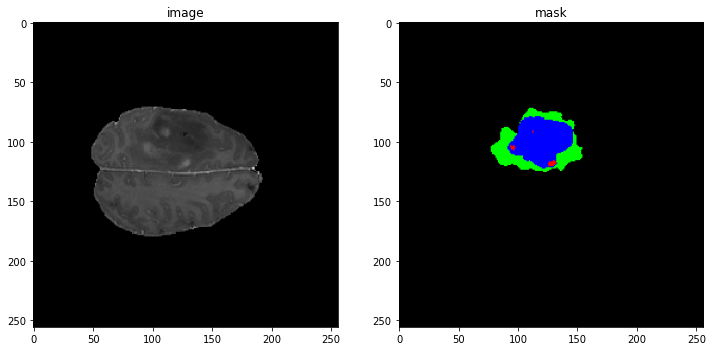

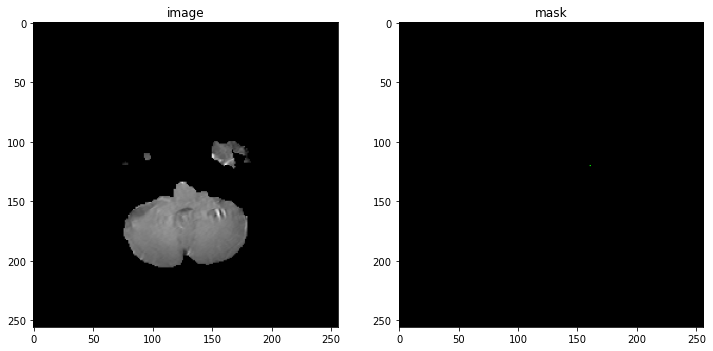

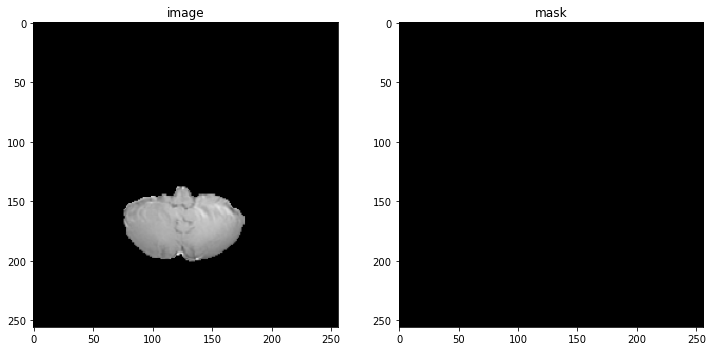

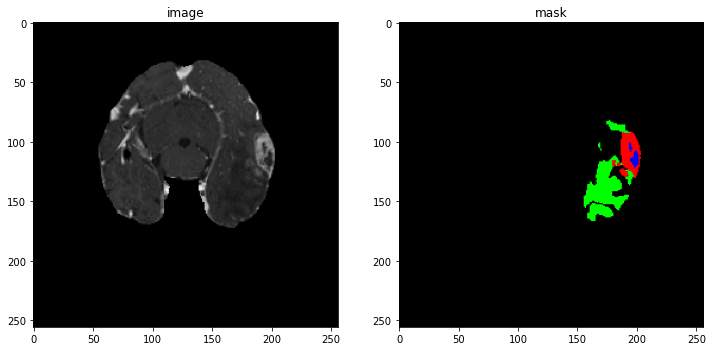

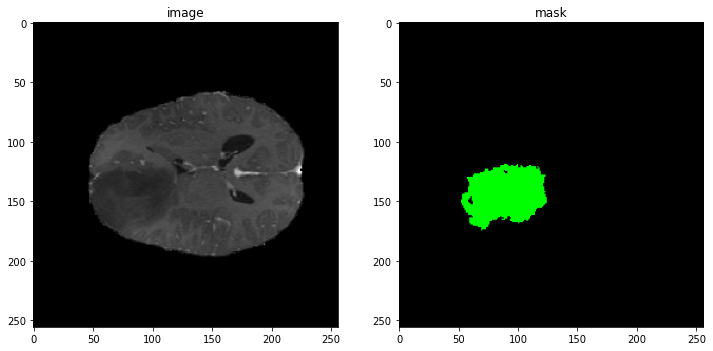

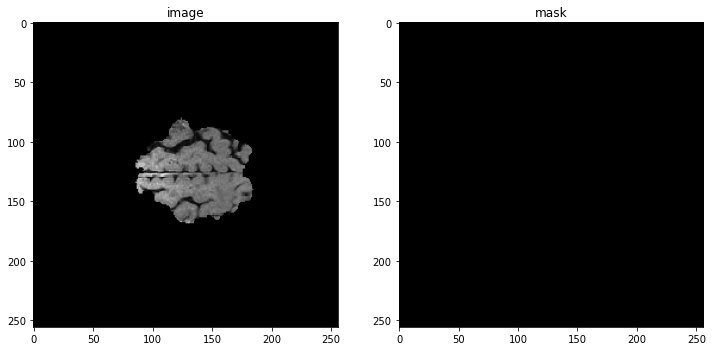

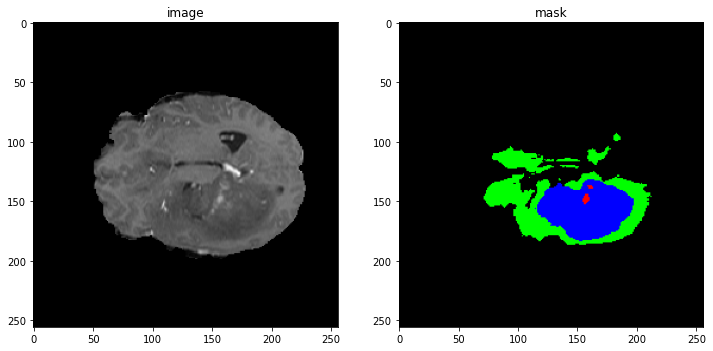

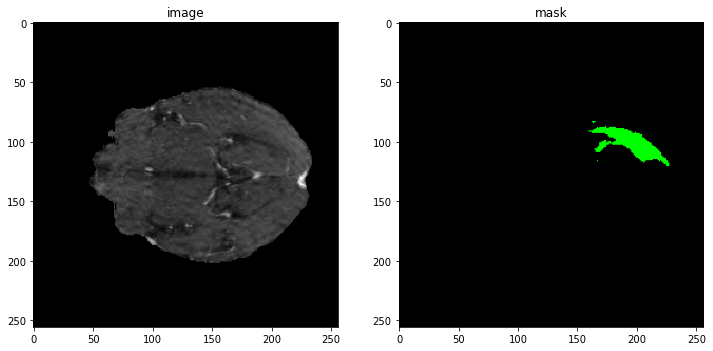

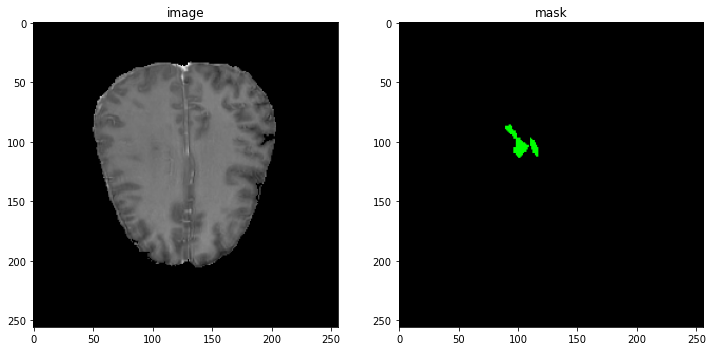

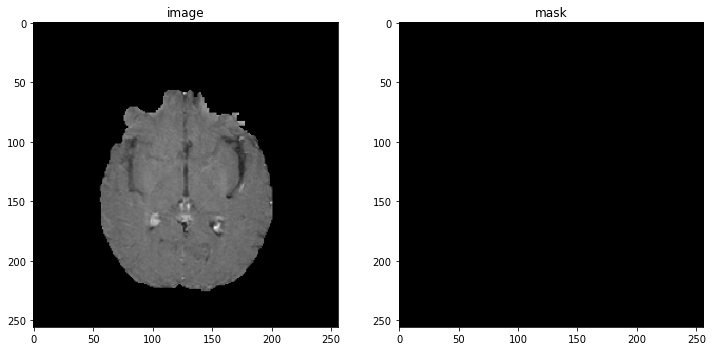

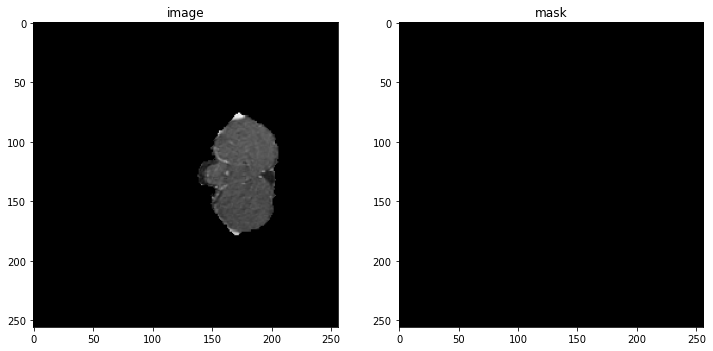

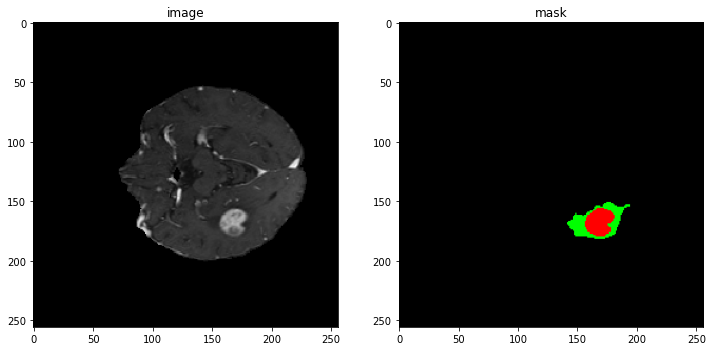

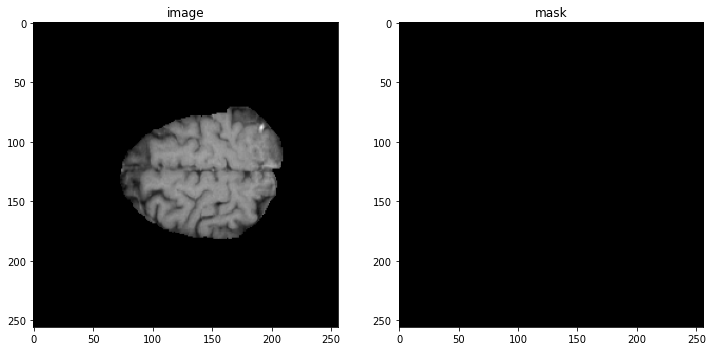

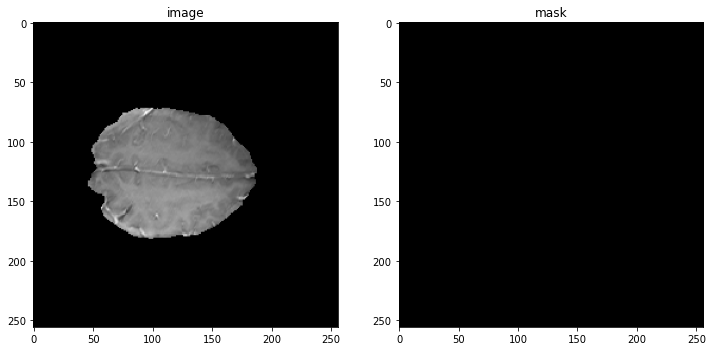

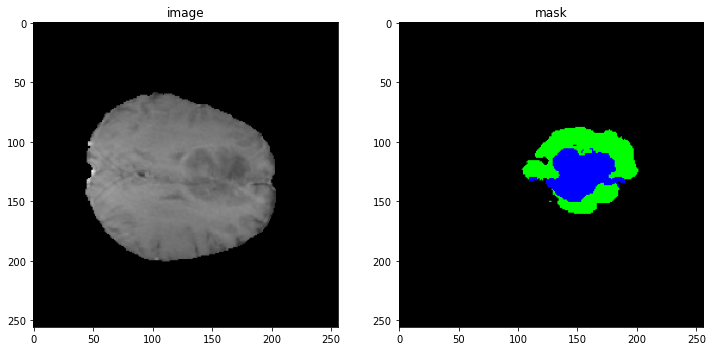

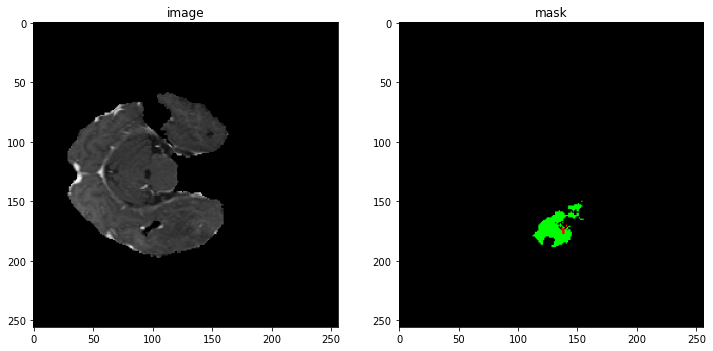

In [17]:
sample = next(iter(train_loader))
for i in range(len(sample[0])):
    f, axes = plt.subplots(1, 2)
    f.set_size_inches(12,12)
    image = sample[0][i]
    image = torch.tensor(image)
    image = image.permute(1,2,0)
    axes[0].imshow(image)
    axes[0].set_title('image')
    mask = sample[1][i]
    mask = torch.tensor(mask)
    mask = mask.permute(1,2,0)
    axes[1].set_title('mask')
    axes[1].imshow(mask)

<ipython-input-18-c5aa5fc0cad1>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)
<ipython-input-18-c5aa5fc0cad1>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask)


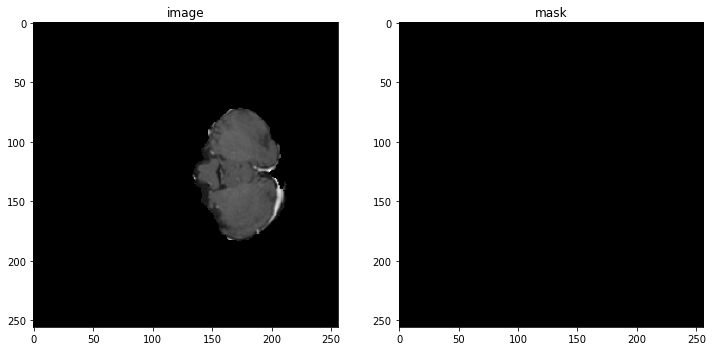

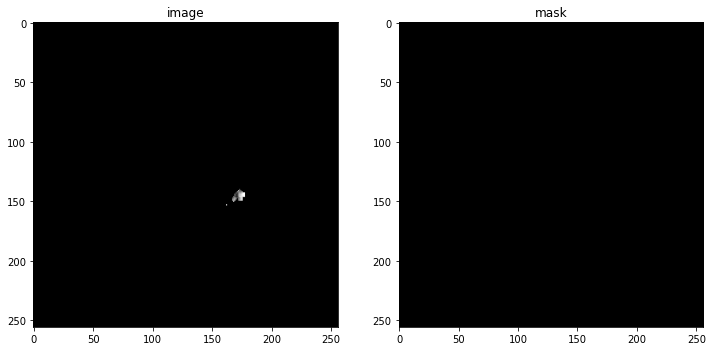

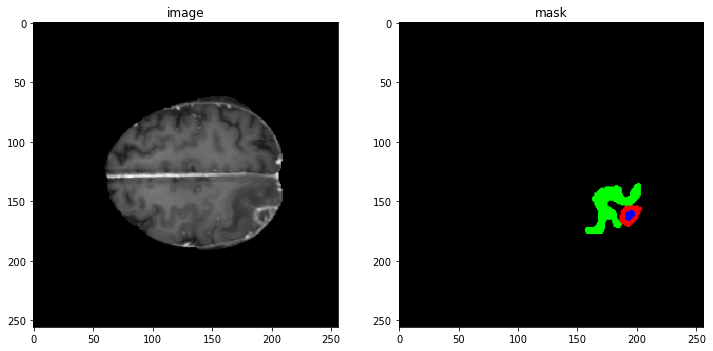

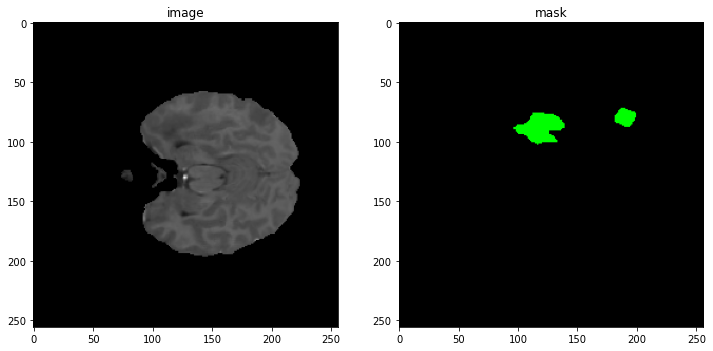

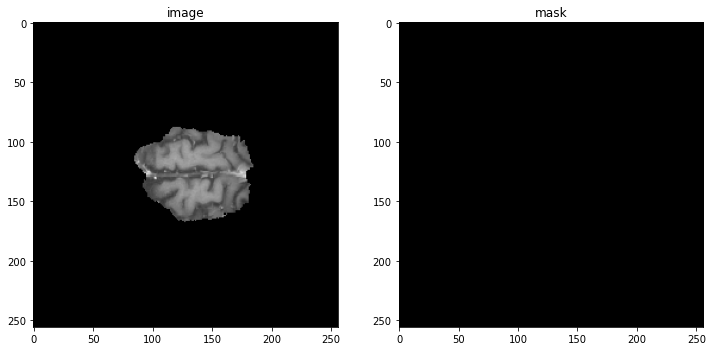

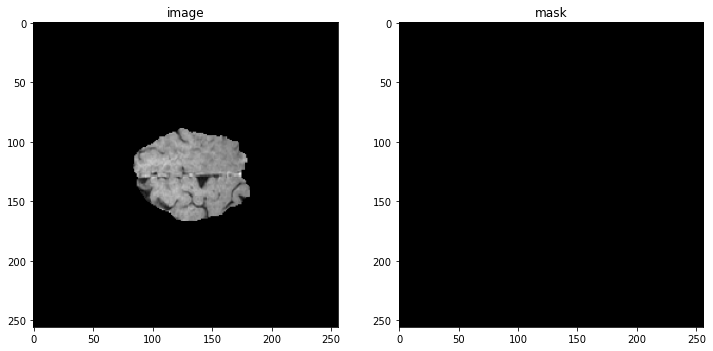

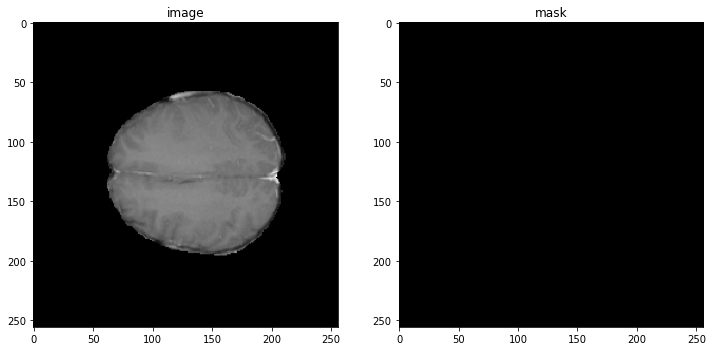

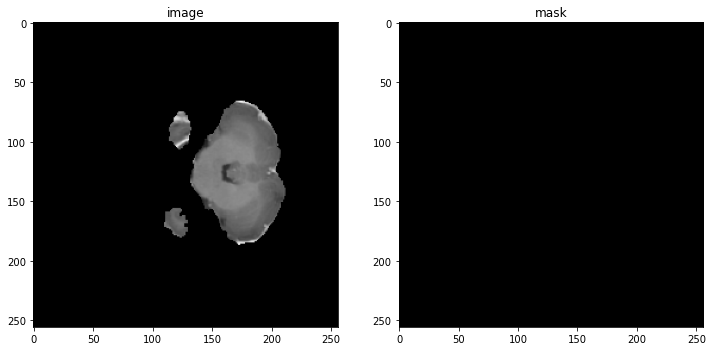

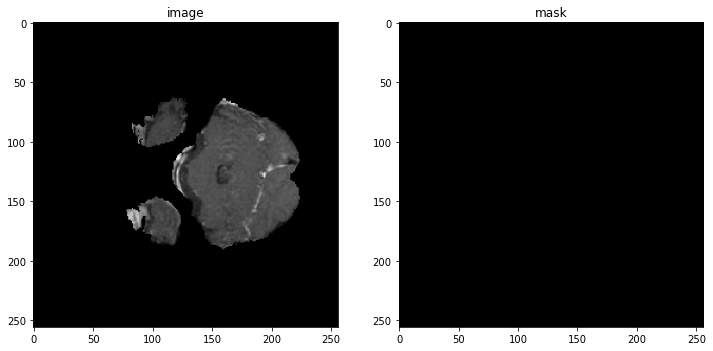

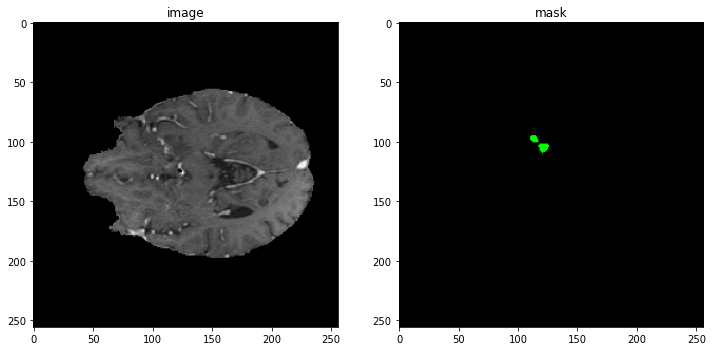

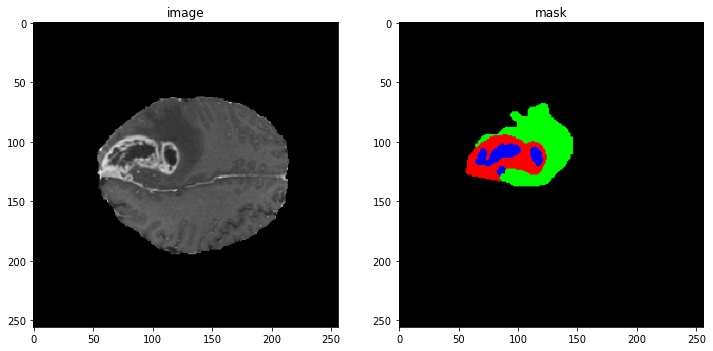

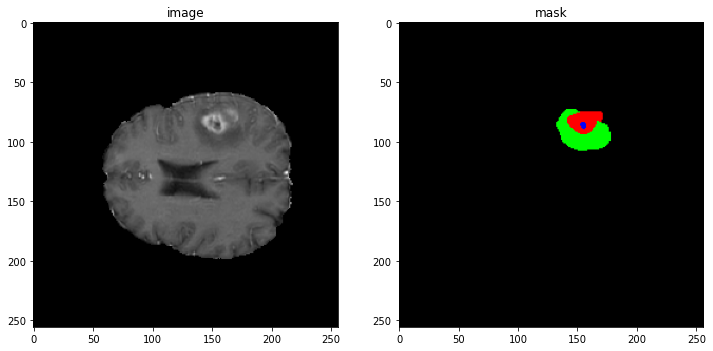

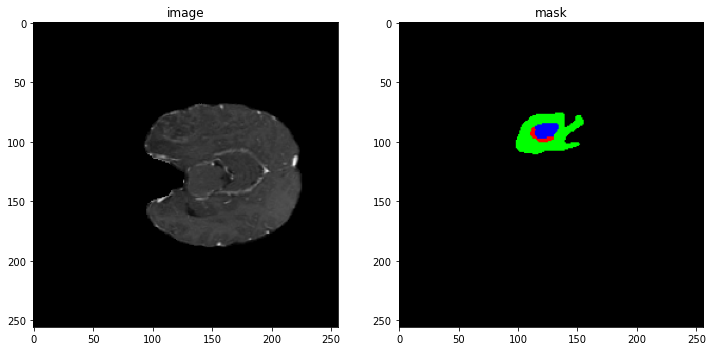

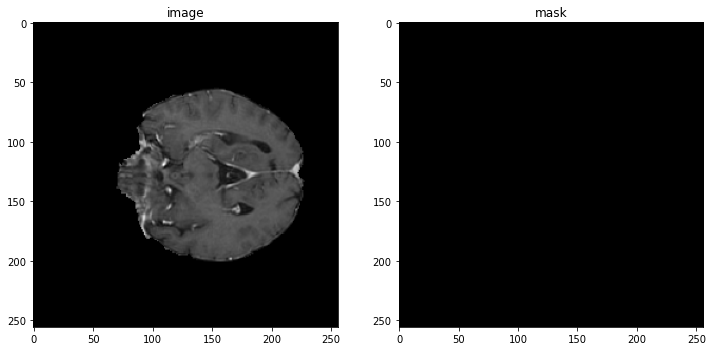

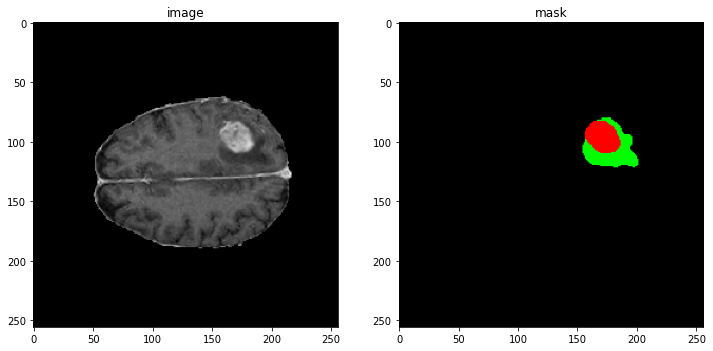

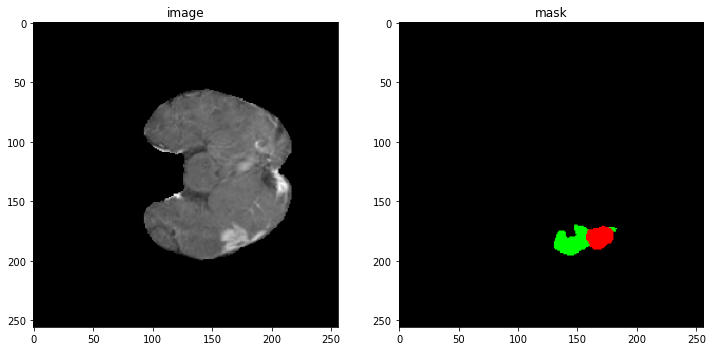

In [18]:
sample = next(iter(val_loader))
for i in range(len(sample[0])):
    f, axes = plt.subplots(1, 2)
    f.set_size_inches(12,12)
    image = sample[0][i]
    image = torch.tensor(image)
    image = image.permute(1,2,0)
    axes[0].imshow(image)
    axes[0].set_title('image')
    mask = sample[1][i]
    mask = torch.tensor(mask)
    mask = mask.permute(1,2,0)
    axes[1].set_title('mask')
    axes[1].imshow(mask)

# Train function, metrics, loss

In [19]:
def dice_score(pred, target, smooth = 1e-6):
    """ This definition generalize to real valued pred and target vector.
        This should be differentiable.
        pred: tensor with first dimension as batch
        target: tensor with first dimension as batch
    """

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return (2. * intersection + smooth) / (A_sum + B_sum + smooth) 

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [21]:
def calc_loss(pred, target, metrics, bce_weight=0.5, dice_weight=0.5, focal_weight=0):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_score(pred, target)
    dice_loss = 1 - dice
    focal_loss = FocalLoss(logits=True)

    loss = bce * bce_weight + dice_loss * dice_weight + focal_weight * focal_loss(pred, target)

    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler,
                bce_weight=0.5, dice_weight=0.5, focal_weight=0,
                num_epochs=25, isDeepLabV3=False):
    loss_train = []
    dice_train = []
    loss_val = []
    dice_val = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = 0

    for epoch in range(num_epochs):
        print(' Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 65)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if isDeepLabV3:
                        outputs = model(inputs)['out']
                    else:
                        outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics, bce_weight, dice_weight, focal_weight)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
            scheduler.step()

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_dice = metrics['dice'] / epoch_samples
            
            if phase == 'train': 
                loss_train.append(epoch_loss)
                dice_train.append(epoch_dice)
            else:
                loss_val.append(epoch_loss)
                dice_val.append(epoch_dice)

            # deep copy the model
            if phase == 'val' and epoch_dice > best_dice:
                print("saving best model")
                best_loss = epoch_loss
                best_dice = epoch_dice
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val dice: {:4f}'.format(best_dice))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_train, dice_train, loss_val, dice_val

In [22]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Plotting

In [23]:
def plot_curves(*paths):
    plt.figure(figsize=(16,8))
    plt.grid(True)
    for i in range(len(paths)):
        with open(paths[i], "r") as f:
            values = f.read()
            values = values.split(",")
            values = values[:-1]
            values = list(map(lambda x: float(x), values))
            f.close()
        plt.plot(values, label=paths[i][38:-13])
    plt.legend()
    plt.show()

# Predict

In [24]:
def predict_masks(model, inputs, isDeepLabV3=False):
    inputs = inputs.to(device)
    if isDeepLabV3:
        pred = model(inputs)['out']
    else:
        pred = model(inputs)
    # The loss functions include the sigmoid function.
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    pred = torch.tensor(pred)
    
    return pred

def plot_predictions(inputs, labels, pred):
    for i in range(len(labels)):
        f, axes = plt.subplots(1, 3)
        f.set_size_inches(12,12)
        image = inputs[i]
        image = image.permute(1,2,0)
        axes[0].imshow(image)
        axes[0].set_title('MRI-photo')
        real_mask = labels[i]
        real_mask = real_mask.permute(1,2,0)
        axes[1].imshow(real_mask)
        axes[1].set_title('real_mask')
        predicted_mask = pred[i]
        predicted_mask = predicted_mask.permute(1,2,0)
        predicted_mask.apply_(lambda x: 1 if x > 0.5 else 0)
        #predicted_mask.apply_(lambda x: 0 if x < 0.1 else x)
        axes[2].set_title('predicted_mask')
        axes[2].imshow(predicted_mask)
        
def show_dices_fot_predict(labels, pred):
    average_dice = 0
    for i in range(len(labels)):
        print(dice_score(labels[i], pred[i]))
        average_dice += dice_score(labels[i], pred[i])
    return average_dice/(len(labels))

# Unet with ResNet18-Encoder 

In [25]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=False)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

# Classic Unet (with dropout)

In [26]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 256x256x3
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(3, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 3, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=0.3)
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        
        dropout1 = self.dropout(maxpool2)

        conv3 = self.double_conv3(dropout1)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        
        dropout2 = self.dropout(maxpool4)
            
        # Bottom
        conv5 = self.double_conv5(dropout2)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

# Train and save

In [27]:
def train_and_save(model, model_name, bce_weight=0.5, 
                    dice_weight=0.5, focal_weight=0, 
                    num_epochs=25, isDeepLabV3=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Device:', device)
    print('Batch size:', batch_size)

    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.3)

    model, loss_train, dice_train, loss_val, dice_val = train_model(model, optimizer_ft,
                                                                    exp_lr_scheduler, num_epochs=num_epochs, 
                                                                    isDeepLabV3=isDeepLabV3,
                                                                    bce_weight=bce_weight,
                                                                    dice_weight=dice_weight,
                                                                    focal_weight=focal_weight)

    save_root = f'C:\\Users\\Admin\\Desktop\\KohanovDiploma\\models_v2\\{model_name}\\epochs_{num_epochs}\\bce{bce_weight}_dice{dice_weight}_focal{focal_weight}\\'
    os.makedirs(save_root)
    
    with open(save_root + 'loss_train.txt', 'w') as filehandle:
        filehandle.writelines("%s," % value for value in loss_train)
        filehandle.close()
    with open(save_root + 'dice_train.txt', 'w') as filehandle:
        filehandle.writelines("%s," % value for value in dice_train)
        filehandle.close()
    with open(save_root + 'loss_val.txt', 'w') as filehandle:
        filehandle.writelines("%s," % value for value in loss_val)
        filehandle.close()
    with open(save_root + 'dice_val.txt', 'w') as filehandle:
        filehandle.writelines("%s," % value for value in dice_val)
        filehandle.close()

    torch.save(model.state_dict(),
               save_root + model_name)
    print('MODEL AND LOGS SAVED TO: ' + save_root)

# Experiements with DeepLabV3 (find the best loss)

In [46]:
from torchvision.models.segmentation import deeplabv3_resnet50

BCE_weight = 0.3, DICE_weight = 0.7, FOCAL_weight = 0

In [26]:
deeplabv3_model = deeplabv3_resnet50(num_classes=3)
deeplabv3_model = deeplabv3_model.to(device)
model_name = 'deeplabv3'

train_and_save(deeplabv3_model, model_name, bce_weight=0.3, 
               dice_weight=0.7, focal_weight=0, 
               num_epochs=30, isDeepLabV3=True)

  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

Device: cuda:0
Batch size: 16
 Epoch 1/30
-----------------------------------------------------------------
LR 0.0001


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.676331, loss: 0.233878


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.766415, loss: 0.165408
saving best model
57m 14s
 Epoch 2/30
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.783232, loss: 0.153473


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.778131, loss: 0.156913
saving best model
56m 48s
 Epoch 3/30
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.814211, loss: 0.131450


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.779504, loss: 0.155911
saving best model
56m 32s
 Epoch 4/30
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.835825, loss: 0.116139


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.784588, loss: 0.152250
saving best model
56m 27s
 Epoch 5/30
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.850289, loss: 0.105899


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.767269, loss: 0.164494
56m 28s
 Epoch 6/30
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.871758, loss: 0.090719


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.785614, loss: 0.151603
saving best model
56m 33s
 Epoch 7/30
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.881778, loss: 0.083642


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.783654, loss: 0.153036
56m 31s
 Epoch 8/30
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.888913, loss: 0.078605


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.781687, loss: 0.154531
56m 33s
 Epoch 9/30
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.892663, loss: 0.075950


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.776797, loss: 0.158003
56m 33s
 Epoch 10/30
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.896671, loss: 0.073118


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.774373, loss: 0.159747
56m 33s
 Epoch 11/30
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.901981, loss: 0.069369


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.776801, loss: 0.158182
56m 34s
 Epoch 12/30
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.904323, loss: 0.067719


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.777055, loss: 0.158025
56m 33s
 Epoch 13/30
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.905935, loss: 0.066582


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.774822, loss: 0.159607
56m 34s
 Epoch 14/30
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.907497, loss: 0.065483


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.773452, loss: 0.160620
56m 35s
 Epoch 15/30
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.908496, loss: 0.064777


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.772771, loss: 0.161154
56m 35s
 Epoch 16/30
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.909902, loss: 0.063784


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.773846, loss: 0.160407
56m 37s
 Epoch 17/30
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.910600, loss: 0.063293


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.774783, loss: 0.159810
56m 38s
 Epoch 18/30
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.911078, loss: 0.062956


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.770951, loss: 0.162494
56m 40s
 Epoch 19/30
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.911502, loss: 0.062658


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.769348, loss: 0.163625
56m 44s
 Epoch 20/30
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.912019, loss: 0.062295


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.770443, loss: 0.162926
56m 45s
 Epoch 21/30
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.912006, loss: 0.062300


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.774434, loss: 0.160129
56m 51s
 Epoch 22/30
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.912443, loss: 0.061995


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.771050, loss: 0.162470
57m 8s
 Epoch 23/30
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.912880, loss: 0.061688


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.771595, loss: 0.162137
57m 24s
 Epoch 24/30
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.912810, loss: 0.061737


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.771014, loss: 0.162520
57m 12s
 Epoch 25/30
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.912745, loss: 0.061782


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.769887, loss: 0.163298
57m 10s
 Epoch 26/30
-----------------------------------------------------------------
LR 2.43e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.912431, loss: 0.062000


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.770007, loss: 0.163264
57m 4s
 Epoch 27/30
-----------------------------------------------------------------
LR 2.43e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.913073, loss: 0.061551


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.770755, loss: 0.162686
57m 8s
 Epoch 28/30
-----------------------------------------------------------------
LR 2.43e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.913362, loss: 0.061349


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.772108, loss: 0.161833
57m 9s
 Epoch 29/30
-----------------------------------------------------------------
LR 2.43e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.913388, loss: 0.061330


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.769464, loss: 0.163599
57m 9s
 Epoch 30/30
-----------------------------------------------------------------
LR 2.43e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.913489, loss: 0.061260


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [04:05<00:00,  3.20it/s]


val: dice: 0.771438, loss: 0.162265
57m 10s
Best val dice: 0.785614
MODEL AND LOGS SAVED TO: C:\Users\Admin\Desktop\KohanovDiploma\models_v2\deeplabv3\epochs_30\bce0.3_dice0.7_focal0\


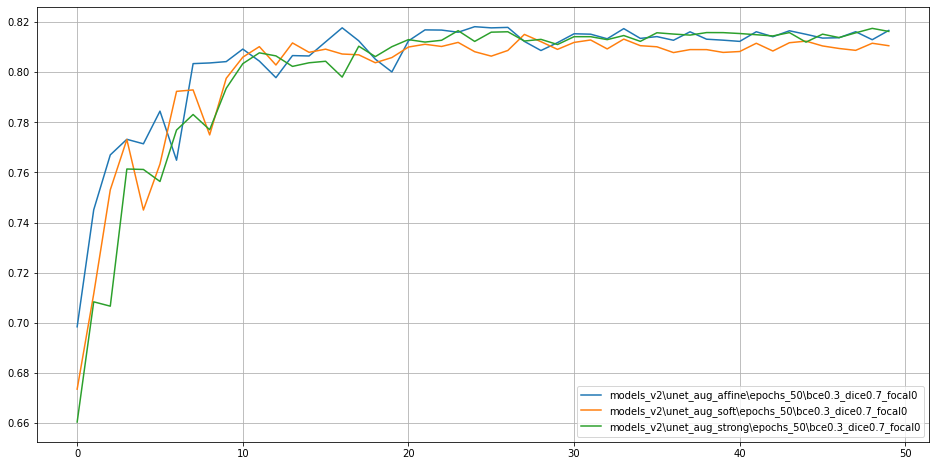

In [51]:
plot_curves('C:\\Users\\Admin\\Desktop\\KohanovDiploma\\models_v2\\unet_aug_affine\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt',
            'C:\\Users\\Admin\\Desktop\\KohanovDiploma\\models_v2\\unet_aug_soft\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt',
            'C:\\Users\\Admin\\Desktop\\KohanovDiploma\\models_v2\\unet_aug_strong\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt')

BCE_weight = 0.5, DICE_weight = 0.5, FOCAL_weight = 0

In [26]:
deeplabv3_model = deeplabv3_resnet50(num_classes=3)
deeplabv3_model = deeplabv3_model.to(device)
model_name = 'deeplabv3'

train_and_save(deeplabv3_model, model_name, bce_weight=0.5, 
               dice_weight=0.5, focal_weight=0, 
               num_epochs=10, isDeepLabV3=True)

  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

Device: cuda:0
Batch size: 16
 Epoch 1/10
-----------------------------------------------------------------
LR 0.0001


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.669816, loss: 0.177773


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.762182, loss: 0.122008
saving best model
56m 52s
 Epoch 2/10
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.776569, loss: 0.114585


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.767331, loss: 0.118877
saving best model
56m 37s
 Epoch 3/10
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.810323, loss: 0.097142


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.778338, loss: 0.113253
saving best model
56m 39s
 Epoch 4/10
-----------------------------------------------------------------
LR 1e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.846397, loss: 0.078661


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.786945, loss: 0.108883
saving best model
56m 40s
 Epoch 5/10
-----------------------------------------------------------------
LR 1e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.857004, loss: 0.073241


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.783420, loss: 0.110702
56m 41s
 Epoch 6/10
-----------------------------------------------------------------
LR 1.0000000000000002e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.863408, loss: 0.069966


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.784272, loss: 0.110317
56m 41s
 Epoch 7/10
-----------------------------------------------------------------
LR 1.0000000000000002e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.864838, loss: 0.069241


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.776355, loss: 0.114286
56m 45s
 Epoch 8/10
-----------------------------------------------------------------
LR 1.0000000000000002e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.865807, loss: 0.068748


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.777855, loss: 0.113549
56m 45s
 Epoch 9/10
-----------------------------------------------------------------
LR 1.0000000000000002e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.865536, loss: 0.068876


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.779592, loss: 0.112673
56m 45s
 Epoch 10/10
-----------------------------------------------------------------
LR 1.0000000000000002e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.865567, loss: 0.068860


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [04:03<00:00,  3.22it/s]


val: dice: 0.783891, loss: 0.110530
56m 44s
Best val dice: 0.786945
MODEL AND LOGS SAVED TO: C:\Users\Admin\Desktop\KohanovDiploma\models_v2\deeplabv3\epochs_10\bce0.5_dice0.5_focal0\


BCE_weight = 0.3, DICE_weight = 0.2, FOCAL_weight = 0.5

In [27]:
deeplabv3_model = deeplabv3_resnet50(num_classes=3)
deeplabv3_model = deeplabv3_model.to(device)
model_name = 'deeplabv3'

train_and_save(deeplabv3_model, model_name, bce_weight=0.3, 
               dice_weight=0.2, focal_weight=0.5, 
               num_epochs=10, isDeepLabV3=True)

  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

Device: cuda:0
Batch size: 16
 Epoch 1/10
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.670786, loss: 0.162721


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.772116, loss: 0.134062
saving best model
56m 42s
 Epoch 2/10
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.779797, loss: 0.132499


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.780686, loss: 0.132184
saving best model
56m 47s
 Epoch 3/10
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.814912, loss: 0.125042


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.735351, loss: 0.141607
56m 43s
 Epoch 4/10
-----------------------------------------------------------------
LR 1e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.847346, loss: 0.118260


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.786475, loss: 0.130784
saving best model
56m 43s
 Epoch 5/10
-----------------------------------------------------------------
LR 1e-05


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.859445, loss: 0.115735


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.784095, loss: 0.131307
56m 46s
 Epoch 6/10
-----------------------------------------------------------------
LR 1.0000000000000002e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.865743, loss: 0.114422


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.784200, loss: 0.131279
56m 44s
 Epoch 7/10
-----------------------------------------------------------------
LR 1.0000000000000002e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.867119, loss: 0.114139


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.780172, loss: 0.132119
56m 47s
 Epoch 8/10
-----------------------------------------------------------------
LR 1.0000000000000002e-06


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.868229, loss: 0.113908


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.780801, loss: 0.132007
56m 45s
 Epoch 9/10
-----------------------------------------------------------------
LR 1.0000000000000002e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.868370, loss: 0.113875


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.782636, loss: 0.131619
56m 45s
 Epoch 10/10
-----------------------------------------------------------------
LR 1.0000000000000002e-07


  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

train: dice: 0.869383, loss: 0.113671


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [04:04<00:00,  3.21it/s]


val: dice: 0.776235, loss: 0.132914
56m 45s
Best val dice: 0.786475
MODEL AND LOGS SAVED TO: C:\Users\Admin\Desktop\KohanovDiploma\models_v2\deeplabv3\epochs_10\bce0.3_dice0.2_focal0.5\


ЛУЧШИЙ ЛОСС ДЛЯ DEEPLABV3 - bce03_dice02_focal05

In [52]:
unet_model = Unet().to(device)
unet_model.load_state_dict(torch.load('C:\\Users\\Admin\\Desktop\\KohanovDiploma\\models_v2\\unet_aug_affine\\epochs_50\\bce0.3_dice0.7_focal0\\unet_aug_affine'))
unet_model.eval()

Unet(
  (double_conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

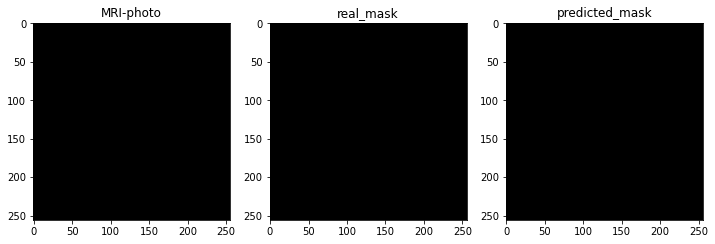

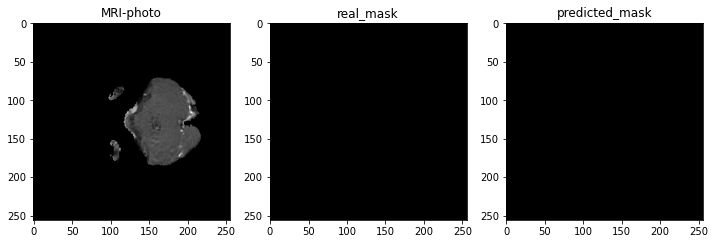

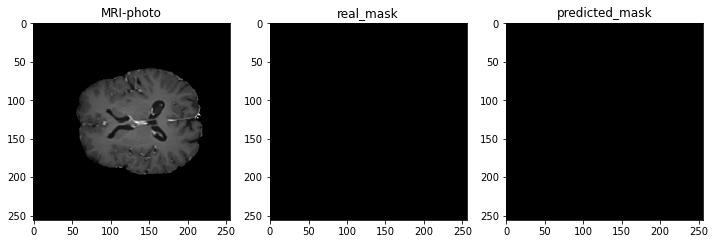

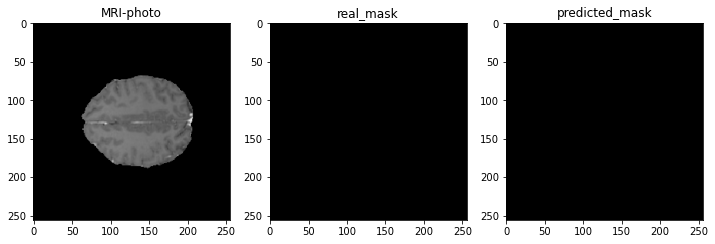

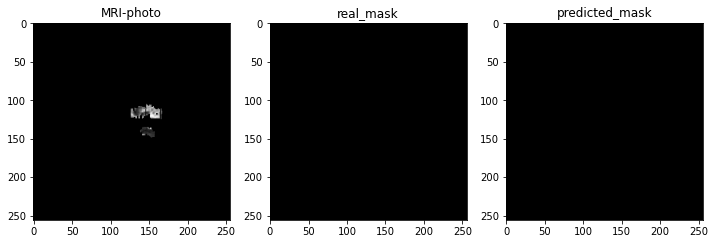

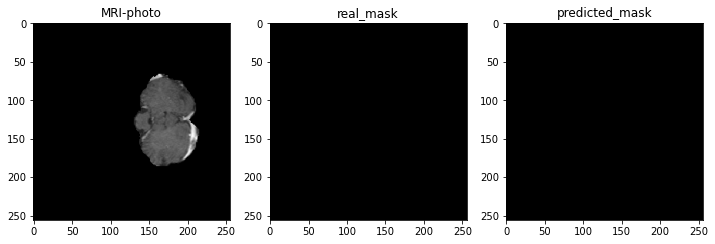

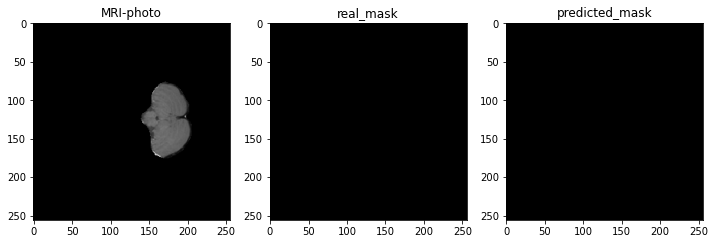

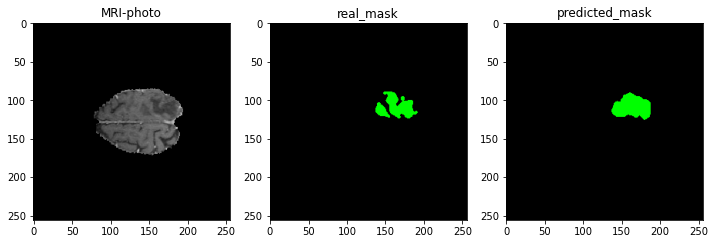

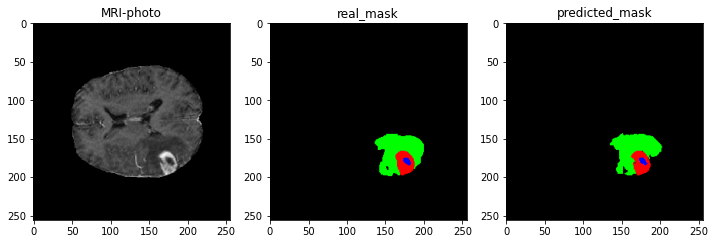

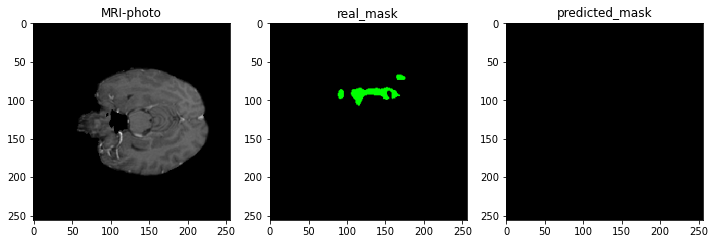

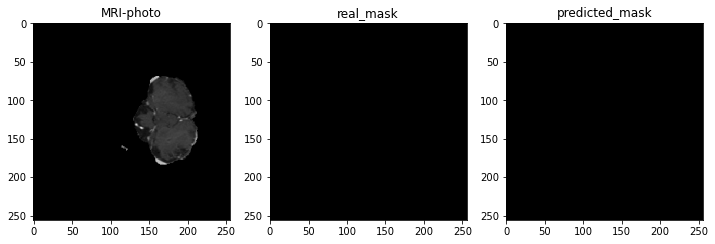

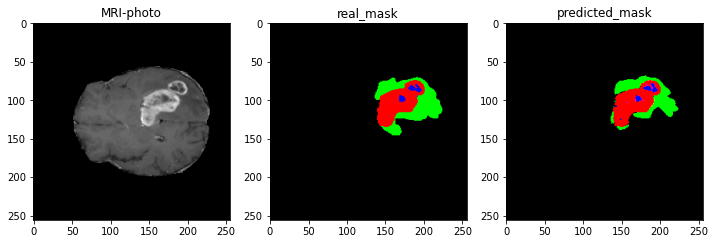

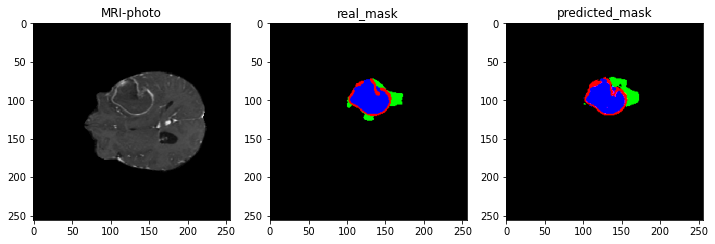

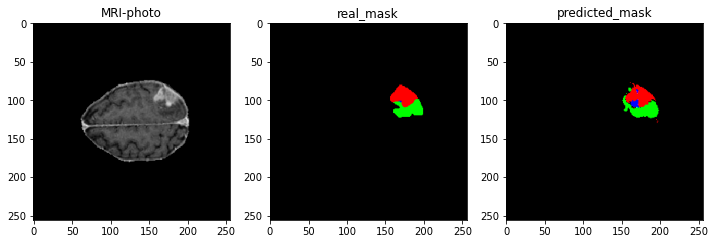

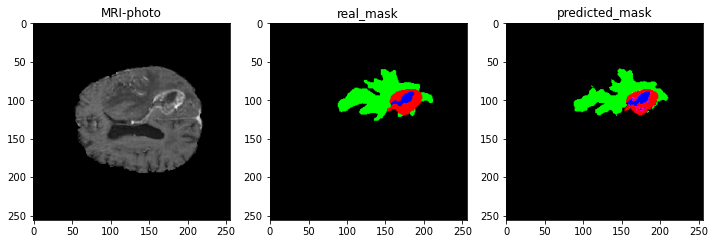

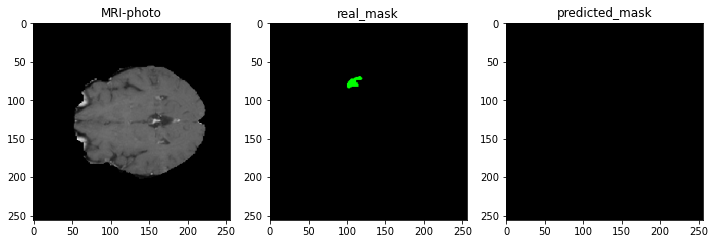

In [53]:
inputs, labels = next(iter(val_loader))

inputs = inputs.to(device)

pred = predict_masks(unet_model, inputs, isDeepLabV3=False)

inputs = inputs.data.cpu().numpy()
inputs = torch.tensor(inputs)
labels = labels.to(device)
labels = labels.data.cpu().numpy()
labels = torch.tensor(labels)

plot_predictions(inputs, labels, pred)

In [36]:
average_dice = show_dices_fot_predict(labels, pred)
average_dice

tensor(0.6305)
tensor(0.7996)
tensor(0.8693)
tensor(0.8156)
tensor(0.8100)
tensor(0.2931)
tensor(1.)
tensor(0.6390)
tensor(0.8789)
tensor(0.7983)
tensor(0.8075)
tensor(0.4411)
tensor(1.)
tensor(0.8315)
tensor(0.8161)
tensor(1.)


tensor(0.7769)

# Experiements with Unet (find the best loss)

BCE_weight = 0.3, DICE_weight = 0.7, FOCAL_weight = 0

In [27]:
unet_model = Unet().to(device)

model_name = 'unet'

train_and_save(unet_model, model_name, bce_weight=0.3, 
               dice_weight=0.7, focal_weight=0, 
               num_epochs=50, isDeepLabV3=False)

  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

Device: cuda:0
Batch size: 16
 Epoch 1/50
-----------------------------------------------------------------
LR 0.0001


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|▎                                                                               | 15/3575 [00:03<14:20,  4.14it/s]


KeyboardInterrupt: 

BCE_weight = 0.5, DICE_weight = 0.5, FOCAL_weight = 0

In [ ]:
unet_model = Unet().to(device)

model_name = 'unet'

train_and_save(unet_model, model_name, bce_weight=0.5, 
               dice_weight=0.5, focal_weight=0, 
               num_epochs=50, isDeepLabV3=False)

BCE_weight = 0.3, DICE_weight = 0.2, FOCAL_weight = 0.5

In [ ]:
unet_model = Unet().to(device)

model_name = 'unet'

train_and_save(unet_model, model_name, bce_weight=0.3, 
               dice_weight=0.2, focal_weight=0.5, 
               num_epochs=50, isDeepLabV3=False)

Unet losses on Validation (50 epochs)

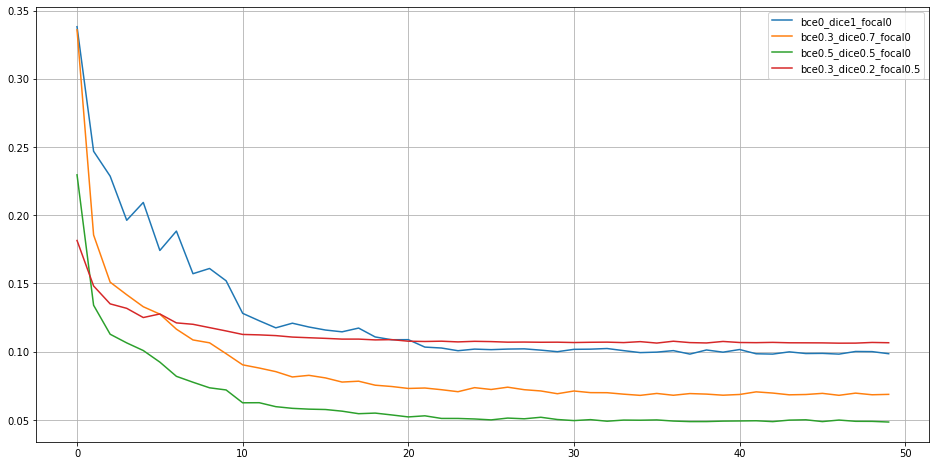

In [30]:
plot_curves('models\\unet\\epochs_50\\bce0_dice1_focal0\\loss_val.txt',
            'models\\unet\\epochs_50\\bce0.3_dice0.7_focal0\\loss_val.txt',
            'models\\unet\\epochs_50\\bce0.5_dice0.5_focal0\\loss_val.txt',
            'models\\unet\\epochs_50\\bce0.3_dice0.2_focal0.5\\loss_val.txt')

Unet dices on validation (50 epochs)

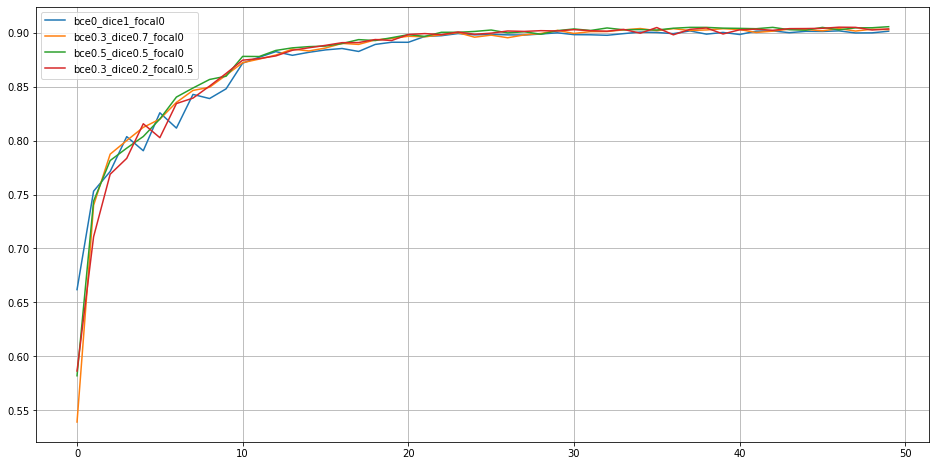

In [29]:
plot_curves('models\\unet\\epochs_50\\bce0_dice1_focal0\\dice_val.txt',
            'models\\unet\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt',
            'models\\unet\\epochs_50\\bce0.5_dice0.5_focal0\\dice_val.txt',
            'models\\unet\\epochs_50\\bce0.3_dice0.2_focal0.5\\dice_val.txt')

ЛУЧШИЙ ЛОСС ДЛЯ UNet - bce05_dice05_focal0

# Experiements with TernausNet (find the best loss)

BCE_weight = 0.3, DICE_weight = 0.7, FOCAL_weight = 0

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('Batch size: ', batch_size)

num_class = 3
resnet_unet_model = ResNetUNet(num_class).to(device)
model_name = 'ternausnet'

train_and_save(resnet_unet_model, model_name, bce_weight=0.3, 
               dice_weight=0.7, focal_weight=0, 
               num_epochs=50, isDeepLabV3=False)

cuda:0
Batch size:  16
Device: cuda:0
Batch size: 16
 Epoch 1/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]


TypeError: __call__() got an unexpected keyword argument 'image'

BCE_weight = 0.5, DICE_weight = 0.5, FOCAL_weight = 0

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('Batch size: ', batch_size)

num_class = 3
resnet_unet_model = ResNetUNet(num_class).to(device)
model_name = 'ternausnet'

train_and_save(resnet_unet_model, model_name, bce_weight=0.5, 
               dice_weight=0.5, focal_weight=0, 
               num_epochs=50, isDeepLabV3=False)

BCE_weight = 0.3, DICE_weight = 0.2, FOCAL_weight = 0.5

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('Batch size: ', batch_size)

num_class = 3
resnet_unet_model = ResNetUNet(num_class).to(device)
model_name = 'ternausnet'

train_and_save(resnet_unet_model, model_name, bce_weight=0.3, 
               dice_weight=0.2, focal_weight=0.5, 
               num_epochs=50, isDeepLabV3=False)

# Experiements with unet (augmentations)

affine

In [22]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2(transpose_mask=True)
    
])

val_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    ToTensorV2(transpose_mask=True)
])

train_dataset = BratsDataset(train_paths, train_transform)
val_dataset = BratsDataset(val_paths, val_transform)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_loader,
               'val': val_loader}

unet_model = Unet().to(device)

model_name = 'unet_aug_affine'

train_and_save(unet_model, model_name, bce_weight=0.3, 
               dice_weight=0.7, focal_weight=0, 
               num_epochs=50, isDeepLabV3=False)

  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

Device: cuda:0
Batch size: 16
 Epoch 1/50
-----------------------------------------------------------------
LR 0.0001


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|                                                                                  | 1/785 [00:00<01:21,  9.64it/s]

train: dice: 0.313676, loss: 0.540276


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.698422, loss: 0.216860
saving best model
11m 40s
 Epoch 2/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:55,  6.79it/s]

train: dice: 0.672080, loss: 0.233673


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.745089, loss: 0.181197
saving best model
11m 40s
 Epoch 3/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:55,  6.82it/s]

train: dice: 0.697866, loss: 0.214199


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.766977, loss: 0.165161
saving best model
11m 41s
 Epoch 4/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.716468, loss: 0.200716


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.773201, loss: 0.160472
saving best model
11m 41s
 Epoch 5/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:56,  6.73it/s]

train: dice: 0.725396, loss: 0.194276


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.771408, loss: 0.161638
11m 41s
 Epoch 6/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:46,  7.35it/s]

train: dice: 0.733951, loss: 0.188187


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.784435, loss: 0.152420
saving best model
11m 42s
 Epoch 7/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:46,  7.35it/s]

train: dice: 0.739413, loss: 0.184303


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.764865, loss: 0.166331
11m 42s
 Epoch 8/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.748072, loss: 0.178180


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.803388, loss: 0.138945
saving best model
11m 41s
 Epoch 9/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:48,  7.21it/s]

train: dice: 0.749398, loss: 0.177227


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.803656, loss: 0.138792
saving best model
11m 40s
 Epoch 10/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:52,  6.99it/s]

train: dice: 0.754471, loss: 0.173629


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.804192, loss: 0.138386
saving best model
11m 41s
 Epoch 11/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:54,  6.86it/s]

train: dice: 0.774608, loss: 0.159403


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.809183, loss: 0.134872
saving best model
11m 41s
 Epoch 12/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:56,  6.72it/s]

train: dice: 0.778086, loss: 0.156938


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.804395, loss: 0.138276
11m 41s
 Epoch 13/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.777249, loss: 0.157507


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.797788, loss: 0.143007
11m 41s
 Epoch 14/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.780299, loss: 0.155360


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.806598, loss: 0.136680
11m 41s
 Epoch 15/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.783224, loss: 0.153297


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.806435, loss: 0.136772
11m 41s
 Epoch 16/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.784162, loss: 0.152628


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812072, loss: 0.132788
saving best model
11m 40s
 Epoch 17/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.787745, loss: 0.150105


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.817670, loss: 0.128852
saving best model
11m 41s
 Epoch 18/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:48,  7.24it/s]

train: dice: 0.789753, loss: 0.148689


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812491, loss: 0.132521
11m 41s
 Epoch 19/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:46,  7.35it/s]

train: dice: 0.790556, loss: 0.148118


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.805168, loss: 0.137641
11m 41s
 Epoch 20/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:54,  6.85it/s]

train: dice: 0.791225, loss: 0.147641


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.800078, loss: 0.141301
11m 41s
 Epoch 21/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:54,  6.83it/s]

train: dice: 0.796252, loss: 0.144081


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812456, loss: 0.132542
11m 41s
 Epoch 22/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:55,  6.76it/s]

train: dice: 0.798294, loss: 0.142643


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.816845, loss: 0.129418
11m 41s
 Epoch 23/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  7.00it/s]

train: dice: 0.798809, loss: 0.142274


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.816771, loss: 0.129488
11m 41s
 Epoch 24/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:55,  6.82it/s]

train: dice: 0.798150, loss: 0.142731


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.815908, loss: 0.130097
11m 41s
 Epoch 25/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.800169, loss: 0.141313


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.818121, loss: 0.128535
saving best model
11m 40s
 Epoch 26/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.800126, loss: 0.141337


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.817654, loss: 0.128832
11m 40s
 Epoch 27/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:57,  6.68it/s]

train: dice: 0.801695, loss: 0.140236


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.817840, loss: 0.128720
11m 40s
 Epoch 28/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:57,  6.68it/s]

train: dice: 0.800803, loss: 0.140858


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812246, loss: 0.132686
11m 41s
 Epoch 29/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:45,  7.41it/s]

train: dice: 0.802862, loss: 0.139410


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808616, loss: 0.135239
11m 41s
 Epoch 30/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.803587, loss: 0.138902


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811764, loss: 0.133009
11m 41s
 Epoch 31/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:45,  7.41it/s]

train: dice: 0.803818, loss: 0.138725


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.815298, loss: 0.130545
11m 41s
 Epoch 32/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.805482, loss: 0.137560


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.815130, loss: 0.130660
11m 41s
 Epoch 33/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.806812, loss: 0.136626


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.813300, loss: 0.131932
11m 41s
 Epoch 34/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:56,  6.75it/s]

train: dice: 0.804830, loss: 0.138014


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.817348, loss: 0.129090
11m 41s
 Epoch 35/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.806691, loss: 0.136708


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.813454, loss: 0.131828
11m 41s
 Epoch 36/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:56,  6.73it/s]

train: dice: 0.805861, loss: 0.137292


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.814168, loss: 0.131301
11m 41s
 Epoch 37/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:55,  6.77it/s]

train: dice: 0.806508, loss: 0.136831


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812705, loss: 0.132336
11m 45s
 Epoch 38/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:54,  6.85it/s]

train: dice: 0.806967, loss: 0.136509


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.816081, loss: 0.129976
11m 41s
 Epoch 39/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:56,  6.73it/s]

train: dice: 0.807369, loss: 0.136228


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.813132, loss: 0.132040
11m 41s
 Epoch 40/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:48,  7.20it/s]

train: dice: 0.806438, loss: 0.136881


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812744, loss: 0.132329
11m 41s
 Epoch 41/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.807878, loss: 0.135868


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812259, loss: 0.132645
11m 42s
 Epoch 42/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.809299, loss: 0.134869


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.816103, loss: 0.129964
11m 42s
 Epoch 43/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:55,  6.77it/s]

train: dice: 0.807390, loss: 0.136210


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.814118, loss: 0.131350
11m 41s
 Epoch 44/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:55,  6.80it/s]

train: dice: 0.807229, loss: 0.136319


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.816490, loss: 0.129672
11m 41s
 Epoch 45/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.807606, loss: 0.136054


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.815090, loss: 0.130672
11m 41s
 Epoch 46/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.808542, loss: 0.135399


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.813571, loss: 0.131724
11m 41s
 Epoch 47/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:48,  7.20it/s]

train: dice: 0.807140, loss: 0.136381


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.813721, loss: 0.131621
11m 41s
 Epoch 48/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:55,  6.79it/s]

train: dice: 0.808439, loss: 0.135473


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.816117, loss: 0.129950
11m 42s
 Epoch 49/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:55,  6.79it/s]

train: dice: 0.808957, loss: 0.135107


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812923, loss: 0.132196
11m 42s
 Epoch 50/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:48,  7.20it/s]

train: dice: 0.807508, loss: 0.136119


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [00:57<00:00, 13.60it/s]

val: dice: 0.816633, loss: 0.129581
11m 41s
Best val dice: 0.818121
MODEL AND LOGS SAVED TO: C:\Users\Admin\Desktop\KohanovDiploma\models_v2\unet_aug_affine\epochs_50\bce0.3_dice0.7_focal0\


soft

In [22]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    ToTensorV2(transpose_mask=True)
])

val_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    ToTensorV2(transpose_mask=True)
])


train_dataset = BratsDataset(train_paths, train_transform)
val_dataset = BratsDataset(val_paths, val_transform)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_loader,
               'val': val_loader}

unet_model = Unet().to(device)

model_name = 'unet_aug_soft'

train_and_save(unet_model, model_name, bce_weight=0.3, 
               dice_weight=0.7, focal_weight=0, 
               num_epochs=50, isDeepLabV3=False)

  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

Device: cuda:0
Batch size: 16
 Epoch 1/50
-----------------------------------------------------------------
LR 0.0001


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|                                                                                  | 1/785 [00:00<01:18,  9.99it/s]

train: dice: 0.270905, loss: 0.573458


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.673545, loss: 0.235286
saving best model
11m 52s
 Epoch 2/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:46,  7.35it/s]

train: dice: 0.648776, loss: 0.250502


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.711530, loss: 0.205324
saving best model
11m 41s
 Epoch 3/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:52,  6.94it/s]

train: dice: 0.685628, loss: 0.223004


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.753048, loss: 0.175111
saving best model
11m 41s
 Epoch 4/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:48,  7.24it/s]

train: dice: 0.702803, loss: 0.210453


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.773122, loss: 0.160511
saving best model
11m 42s
 Epoch 5/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:55,  6.80it/s]

train: dice: 0.714340, loss: 0.202152


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.744989, loss: 0.180463
11m 42s
 Epoch 6/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:53,  6.90it/s]

train: dice: 0.722822, loss: 0.196101


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.763345, loss: 0.167426
11m 42s
 Epoch 7/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.730142, loss: 0.190890


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.792327, loss: 0.146778
saving best model
11m 42s
 Epoch 8/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:49,  7.15it/s]

train: dice: 0.738318, loss: 0.185100


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.792897, loss: 0.146331
saving best model
11m 42s
 Epoch 9/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:56,  6.71it/s]

train: dice: 0.743442, loss: 0.181462


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.774955, loss: 0.159060
11m 43s
 Epoch 10/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.749955, loss: 0.176856


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.797528, loss: 0.143028
saving best model
11m 43s
 Epoch 11/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:55,  6.80it/s]

train: dice: 0.764817, loss: 0.166315


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.805955, loss: 0.137154
saving best model
11m 43s
 Epoch 12/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:55,  6.76it/s]

train: dice: 0.770954, loss: 0.161986


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.810163, loss: 0.134148
saving best model
11m 43s
 Epoch 13/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:52,  6.94it/s]

train: dice: 0.771224, loss: 0.161783


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.802843, loss: 0.139333
11m 43s
 Epoch 14/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:57,  6.67it/s]

train: dice: 0.776484, loss: 0.158072


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811642, loss: 0.133088
saving best model
11m 42s
 Epoch 15/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:55,  6.77it/s]

train: dice: 0.778006, loss: 0.156994


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.807892, loss: 0.135721
11m 42s
 Epoch 16/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:45,  7.41it/s]

train: dice: 0.779101, loss: 0.156216


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.809157, loss: 0.134837
11m 42s
 Epoch 17/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:50,  7.09it/s]

train: dice: 0.779574, loss: 0.155871


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.807222, loss: 0.136244
11m 42s
 Epoch 18/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:50,  7.09it/s]

train: dice: 0.781807, loss: 0.154288


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.806901, loss: 0.136477
11m 42s
 Epoch 19/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:54,  6.85it/s]

train: dice: 0.783392, loss: 0.153169


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.803742, loss: 0.138710
11m 43s
 Epoch 20/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:54,  6.86it/s]

train: dice: 0.785540, loss: 0.151660


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.805809, loss: 0.137209
11m 42s
 Epoch 21/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  6.99it/s]

train: dice: 0.791185, loss: 0.147665


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.810006, loss: 0.134251
11m 42s
 Epoch 22/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.792748, loss: 0.146559


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811104, loss: 0.133489
11m 42s
 Epoch 23/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:55,  6.78it/s]

train: dice: 0.794312, loss: 0.145458


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.810230, loss: 0.134091
11m 42s
 Epoch 24/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:50,  7.09it/s]

train: dice: 0.794556, loss: 0.145282


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811854, loss: 0.132951
saving best model
11m 45s
 Epoch 25/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.793957, loss: 0.145698


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808140, loss: 0.135574
11m 42s
 Epoch 26/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.795133, loss: 0.144867


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.806374, loss: 0.136807
11m 42s
 Epoch 27/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.795878, loss: 0.144343


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808632, loss: 0.135216
11m 41s
 Epoch 28/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:49,  7.15it/s]

train: dice: 0.796248, loss: 0.144081


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.815039, loss: 0.130722
saving best model
11m 41s
 Epoch 29/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.796877, loss: 0.143638


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812143, loss: 0.132730
11m 41s
 Epoch 30/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.797783, loss: 0.142995


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.809071, loss: 0.134919
11m 41s
 Epoch 31/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:58,  6.64it/s]

train: dice: 0.799811, loss: 0.141566


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811850, loss: 0.132938
11m 41s
 Epoch 32/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:48,  7.19it/s]

train: dice: 0.801506, loss: 0.140372


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812818, loss: 0.132281
11m 41s
 Epoch 33/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:55,  6.76it/s]

train: dice: 0.800552, loss: 0.141039


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.809255, loss: 0.134779
11m 42s
 Epoch 34/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:44,  7.50it/s]

train: dice: 0.801641, loss: 0.140279


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.813165, loss: 0.132012
11m 41s
 Epoch 35/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.801764, loss: 0.140189


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.810547, loss: 0.133869
11m 41s
 Epoch 36/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.802474, loss: 0.139691


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.810103, loss: 0.134147
11m 41s
 Epoch 37/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:55,  6.79it/s]

train: dice: 0.802219, loss: 0.139867


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.807795, loss: 0.135795
11m 41s
 Epoch 38/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:46,  7.34it/s]

train: dice: 0.802527, loss: 0.139651


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808983, loss: 0.134965
11m 41s
 Epoch 39/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.801165, loss: 0.140606


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808974, loss: 0.134952
11m 41s
 Epoch 40/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:50,  7.09it/s]

train: dice: 0.802362, loss: 0.139764


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.807862, loss: 0.135760
11m 42s
 Epoch 41/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:44,  7.50it/s]

train: dice: 0.801875, loss: 0.140100


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808216, loss: 0.135483
11m 42s
 Epoch 42/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.803033, loss: 0.139290


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811509, loss: 0.133179
11m 42s
 Epoch 43/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.803026, loss: 0.139295


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808421, loss: 0.135381
11m 41s
 Epoch 44/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.801290, loss: 0.140515


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811725, loss: 0.133031
11m 41s
 Epoch 45/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:44,  7.50it/s]

train: dice: 0.803019, loss: 0.139297


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.812362, loss: 0.132593
11m 40s
 Epoch 46/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:46,  7.35it/s]

train: dice: 0.802623, loss: 0.139573


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.810441, loss: 0.133930
11m 40s
 Epoch 47/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:52,  7.00it/s]

train: dice: 0.803417, loss: 0.139020


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.809426, loss: 0.134673
11m 39s
 Epoch 48/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:55,  6.76it/s]

train: dice: 0.802242, loss: 0.139843


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.808683, loss: 0.135170
11m 40s
 Epoch 49/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.803861, loss: 0.138707


  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

val: dice: 0.811515, loss: 0.133185
11m 40s
 Epoch 50/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:44,  7.48it/s]

train: dice: 0.802738, loss: 0.139497


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [00:57<00:00, 13.62it/s]

val: dice: 0.810525, loss: 0.133888
11m 41s
Best val dice: 0.815039
MODEL AND LOGS SAVED TO: C:\Users\Admin\Desktop\KohanovDiploma\models_v2\unet_aug_soft\epochs_50\bce0.3_dice0.7_focal0\


strong

In [23]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, 
                       rotate_limit=10, p=0.3),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, 
                         sigma=120*0.02, alpha_affine=120*0.03),
        A.GridDistortion(p=0.3),
        A.OpticalDistortion(p=0.3, distort_limit=2, shift_limit=0.2)
    ], p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    ToTensorV2(transpose_mask=True)
])

val_transform = A.Compose([
    A.Resize(256,256,cv2.INTER_NEAREST),
    ToTensorV2(transpose_mask=True)
])


train_dataset = BratsDataset(train_paths, train_transform)
val_dataset = BratsDataset(val_paths, val_transform)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_loader,
               'val': val_loader}

unet_model = Unet().to(device)

model_name = 'unet_aug_strong'

train_and_save(unet_model, model_name, bce_weight=0.3, 
               dice_weight=0.7, focal_weight=0, 
               num_epochs=50, isDeepLabV3=False)

  0%|                                                                                         | 0/3575 [00:00<?, ?it/s]

Device: cuda:0
Batch size: 16
 Epoch 1/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:55,  6.80it/s]

train: dice: 0.274481, loss: 0.555716


  0%|                                                                                 | 1/3575 [00:00<07:31,  7.92it/s]

val: dice: 0.660430, loss: 0.243768
saving best model
11m 41s
 Epoch 2/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.566616, loss: 0.308442


  0%|                                                                                 | 1/3575 [00:00<06:46,  8.79it/s]

val: dice: 0.708375, loss: 0.207121
saving best model
11m 41s
 Epoch 3/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:52,  7.00it/s]

train: dice: 0.603141, loss: 0.281372


  0%|                                                                                 | 1/3575 [00:00<07:28,  7.97it/s]

val: dice: 0.706647, loss: 0.207777
11m 41s
 Epoch 4/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.623060, loss: 0.266982


  0%|                                                                                 | 1/3575 [00:00<08:23,  7.09it/s]

val: dice: 0.761350, loss: 0.168953
saving best model
11m 41s
 Epoch 5/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:48,  7.19it/s]

train: dice: 0.637578, loss: 0.256582


  0%|                                                                                 | 1/3575 [00:00<07:58,  7.46it/s]

val: dice: 0.761173, loss: 0.168976
11m 41s
 Epoch 6/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.644303, loss: 0.251796


  0%|                                                                                 | 1/3575 [00:00<08:23,  7.09it/s]

val: dice: 0.756375, loss: 0.172335
11m 41s
 Epoch 7/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:55,  6.80it/s]

train: dice: 0.653330, loss: 0.245379


  0%|                                                                                 | 1/3575 [00:00<07:58,  7.46it/s]

val: dice: 0.776892, loss: 0.157681
saving best model
11m 41s
 Epoch 8/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:56,  6.74it/s]

train: dice: 0.661263, loss: 0.239769


  0%|                                                                                 | 1/3575 [00:00<07:13,  8.24it/s]

val: dice: 0.783094, loss: 0.153506
saving best model
11m 41s
 Epoch 9/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:56,  6.71it/s]

train: dice: 0.667115, loss: 0.235613


  0%|                                                                                 | 1/3575 [00:00<08:27,  7.04it/s]

val: dice: 0.777021, loss: 0.157675
11m 41s
 Epoch 10/50
-----------------------------------------------------------------
LR 0.0001


  0%|                                                                                  | 1/785 [00:00<01:48,  7.19it/s]

train: dice: 0.673346, loss: 0.231210


  0%|                                                                                 | 1/3575 [00:00<08:47,  6.78it/s]

val: dice: 0.793549, loss: 0.145930
saving best model
11m 41s
 Epoch 11/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:56,  6.75it/s]

train: dice: 0.691008, loss: 0.218690


  0%|                                                                                 | 1/3575 [00:00<08:09,  7.29it/s]

val: dice: 0.803372, loss: 0.138950
saving best model
11m 41s
 Epoch 12/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:54,  6.86it/s]

train: dice: 0.695974, loss: 0.215166


  0%|                                                                                 | 1/3575 [00:00<08:41,  6.85it/s]

val: dice: 0.807691, loss: 0.135953
saving best model
11m 41s
 Epoch 13/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:51,  7.01it/s]

train: dice: 0.697252, loss: 0.214257


  0%|                                                                                 | 1/3575 [00:00<08:51,  6.73it/s]

val: dice: 0.806473, loss: 0.136804
11m 41s
 Epoch 14/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:56,  6.74it/s]

train: dice: 0.700971, loss: 0.211623


  0%|                                                                                 | 1/3575 [00:00<07:35,  7.85it/s]

val: dice: 0.802283, loss: 0.139763
11m 42s
 Epoch 15/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.702857, loss: 0.210294


  0%|                                                                                 | 1/3575 [00:00<07:35,  7.85it/s]

val: dice: 0.803726, loss: 0.138681
11m 42s
 Epoch 16/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:58,  6.64it/s]

train: dice: 0.704541, loss: 0.209085


  0%|                                                                                 | 1/3575 [00:00<07:56,  7.50it/s]

val: dice: 0.804332, loss: 0.138321
11m 42s
 Epoch 17/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.704572, loss: 0.209058


  0%|                                                                                 | 1/3575 [00:00<07:53,  7.55it/s]

val: dice: 0.798023, loss: 0.142784
11m 42s
 Epoch 18/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.708784, loss: 0.206085


  0%|                                                                                 | 1/3575 [00:00<06:10,  9.64it/s]

val: dice: 0.810336, loss: 0.134073
saving best model
11m 42s
 Epoch 19/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:45,  7.41it/s]

train: dice: 0.708230, loss: 0.206467


  0%|                                                                                 | 1/3575 [00:00<07:02,  8.45it/s]

val: dice: 0.806186, loss: 0.137004
11m 42s
 Epoch 20/50
-----------------------------------------------------------------
LR 3e-05


  0%|                                                                                  | 1/785 [00:00<01:54,  6.83it/s]

train: dice: 0.711137, loss: 0.204421


  0%|                                                                                 | 1/3575 [00:00<08:30,  6.99it/s]

val: dice: 0.810142, loss: 0.134210
11m 42s
 Epoch 21/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  7.00it/s]

train: dice: 0.716291, loss: 0.200760


  0%|                                                                                 | 1/3575 [00:00<09:19,  6.39it/s]

val: dice: 0.812964, loss: 0.132205
saving best model
11m 43s
 Epoch 22/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.716726, loss: 0.200451


  0%|                                                                                 | 1/3575 [00:00<06:21,  9.37it/s]

val: dice: 0.811983, loss: 0.132887
11m 42s
 Epoch 23/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:52,  6.95it/s]

train: dice: 0.716624, loss: 0.200513


  0%|                                                                                 | 1/3575 [00:00<06:04,  9.80it/s]

val: dice: 0.812699, loss: 0.132383
11m 42s
 Epoch 24/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.718849, loss: 0.198959


  0%|                                                                                 | 1/3575 [00:00<07:29,  7.96it/s]

val: dice: 0.816536, loss: 0.129646
saving best model
11m 42s
 Epoch 25/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:54,  6.86it/s]

train: dice: 0.718936, loss: 0.198882


  0%|                                                                                 | 1/3575 [00:00<07:04,  8.42it/s]

val: dice: 0.812244, loss: 0.132715
11m 42s
 Epoch 26/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:57,  6.69it/s]

train: dice: 0.719846, loss: 0.198242


  0%|                                                                                 | 1/3575 [00:00<08:27,  7.04it/s]

val: dice: 0.815934, loss: 0.130122
11m 41s
 Epoch 27/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:48,  7.19it/s]

train: dice: 0.722610, loss: 0.196283


  0%|                                                                                 | 1/3575 [00:00<08:23,  7.09it/s]

val: dice: 0.816095, loss: 0.130006
11m 41s
 Epoch 28/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:46,  7.35it/s]

train: dice: 0.720390, loss: 0.197860


  0%|                                                                                 | 1/3575 [00:00<07:06,  8.38it/s]

val: dice: 0.812400, loss: 0.132595
11m 42s
 Epoch 29/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:55,  6.81it/s]

train: dice: 0.720487, loss: 0.197773


  0%|                                                                                 | 1/3575 [00:00<08:51,  6.73it/s]

val: dice: 0.813066, loss: 0.132104
11m 45s
 Epoch 30/50
-----------------------------------------------------------------
LR 9e-06


  0%|                                                                                  | 1/785 [00:00<01:50,  7.09it/s]

train: dice: 0.723184, loss: 0.195882


  0%|                                                                                 | 1/3575 [00:00<07:10,  8.31it/s]

val: dice: 0.811010, loss: 0.133559
11m 41s
 Epoch 31/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:48,  7.19it/s]

train: dice: 0.725300, loss: 0.194394


  0%|                                                                                 | 1/3575 [00:00<07:24,  8.04it/s]

val: dice: 0.814138, loss: 0.131351
11m 41s
 Epoch 32/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.724096, loss: 0.195249


  0%|                                                                                 | 1/3575 [00:00<09:16,  6.43it/s]

val: dice: 0.814134, loss: 0.131360
11m 42s
 Epoch 33/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.726124, loss: 0.193808


  0%|                                                                                 | 1/3575 [00:00<06:53,  8.64it/s]

val: dice: 0.812955, loss: 0.132183
11m 41s
 Epoch 34/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.723215, loss: 0.195845


  0%|                                                                                 | 1/3575 [00:00<08:47,  6.78it/s]

val: dice: 0.814591, loss: 0.131033
11m 41s
 Epoch 35/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:50,  7.09it/s]

train: dice: 0.724027, loss: 0.195273


  0%|                                                                                 | 1/3575 [00:00<09:19,  6.39it/s]

val: dice: 0.812266, loss: 0.132690
11m 41s
 Epoch 36/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:56,  6.71it/s]

train: dice: 0.725708, loss: 0.194102


  0%|                                                                                 | 1/3575 [00:00<06:00,  9.91it/s]

val: dice: 0.815698, loss: 0.130239
11m 41s
 Epoch 37/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:49,  7.14it/s]

train: dice: 0.725925, loss: 0.193934


  0%|                                                                                 | 1/3575 [00:00<07:47,  7.64it/s]

val: dice: 0.815182, loss: 0.130615
11m 41s
 Epoch 38/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:53,  6.90it/s]

train: dice: 0.724688, loss: 0.194816


  0%|                                                                                 | 1/3575 [00:00<06:57,  8.57it/s]

val: dice: 0.814765, loss: 0.130911
11m 41s
 Epoch 39/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:50,  7.09it/s]

train: dice: 0.725898, loss: 0.193962


  0%|                                                                                 | 1/3575 [00:00<07:17,  8.17it/s]

val: dice: 0.815776, loss: 0.130196
11m 42s
 Epoch 40/50
-----------------------------------------------------------------
LR 2.7e-06


  0%|                                                                                  | 1/785 [00:00<01:49,  7.15it/s]

train: dice: 0.725361, loss: 0.194336


  0%|                                                                                 | 1/3575 [00:00<06:36,  9.02it/s]

val: dice: 0.815752, loss: 0.130266
11m 42s
 Epoch 41/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:46,  7.35it/s]

train: dice: 0.724887, loss: 0.194675


  0%|                                                                                 | 1/3575 [00:00<08:16,  7.20it/s]

val: dice: 0.815396, loss: 0.130479
11m 42s
 Epoch 42/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.726663, loss: 0.193418


  0%|                                                                                 | 1/3575 [00:00<08:54,  6.68it/s]

val: dice: 0.814917, loss: 0.130811
11m 42s
 Epoch 43/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.728915, loss: 0.191836


  0%|                                                                                 | 1/3575 [00:00<08:51,  6.73it/s]

val: dice: 0.814424, loss: 0.131150
11m 41s
 Epoch 44/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:51,  7.04it/s]

train: dice: 0.728528, loss: 0.192101


  0%|                                                                                 | 1/3575 [00:00<06:57,  8.56it/s]

val: dice: 0.815764, loss: 0.130234
11m 42s
 Epoch 45/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.726338, loss: 0.193642


  0%|                                                                                 | 1/3575 [00:00<07:35,  7.85it/s]

val: dice: 0.811953, loss: 0.132909
11m 41s
 Epoch 46/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.726010, loss: 0.193871


  0%|                                                                                 | 1/3575 [00:00<08:09,  7.30it/s]

val: dice: 0.815137, loss: 0.130645
11m 41s
 Epoch 47/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:52,  7.00it/s]

train: dice: 0.727593, loss: 0.192756


  0%|                                                                                 | 1/3575 [00:00<07:31,  7.91it/s]

val: dice: 0.813777, loss: 0.131623
11m 41s
 Epoch 48/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:47,  7.30it/s]

train: dice: 0.728794, loss: 0.191898


  0%|                                                                                 | 1/3575 [00:00<08:30,  6.99it/s]

val: dice: 0.815664, loss: 0.130281
11m 41s
 Epoch 49/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:48,  7.25it/s]

train: dice: 0.726163, loss: 0.193765


  0%|                                                                                 | 1/3575 [00:00<07:38,  7.79it/s]

val: dice: 0.817451, loss: 0.129028
saving best model
11m 41s
 Epoch 50/50
-----------------------------------------------------------------
LR 8.1e-07


  0%|                                                                                  | 1/785 [00:00<01:54,  6.85it/s]

train: dice: 0.726245, loss: 0.193711


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [00:57<00:00, 13.60it/s]

val: dice: 0.816226, loss: 0.129890
11m 42s
Best val dice: 0.817451
MODEL AND LOGS SAVED TO: C:\Users\Admin\Desktop\KohanovDiploma\models_v2\unet_aug_strong\epochs_50\bce0.3_dice0.7_focal0\


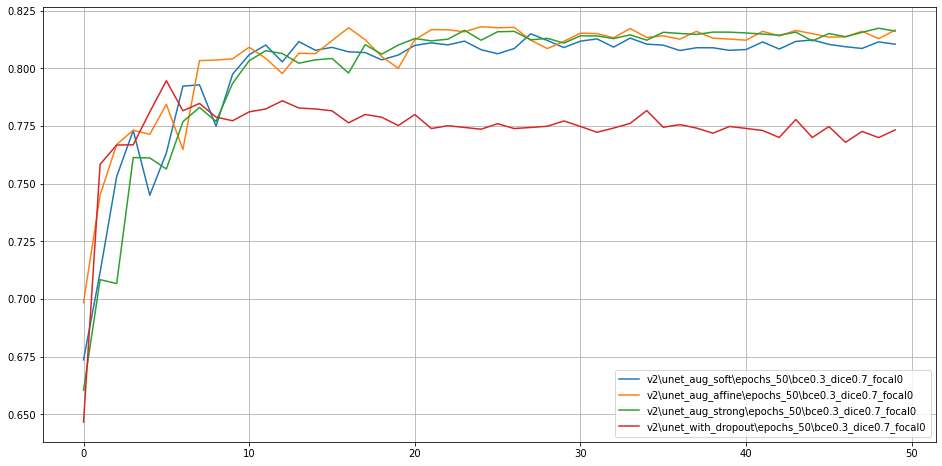

In [26]:
plot_curves('models_v2\\unet_aug_soft\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt',
            'models_v2\\unet_aug_affine\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt',
            'models_v2\\unet_aug_strong\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt',
            'models_v2\\unet_with_dropout\\epochs_50\\bce0.3_dice0.7_focal0\\dice_val.txt')

Лучшая аугментация - афинная (геометрическая)

# Unet prtedictions

In [28]:
unet_model = Unet().to(device)
unet_model.load_state_dict(torch.load('models_v2\\unet_aug_affine\\epochs_50\\bce0.3_dice0.7_focal0\\unet_aug_affine'))
unet_model.eval()

Unet(
  (double_conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

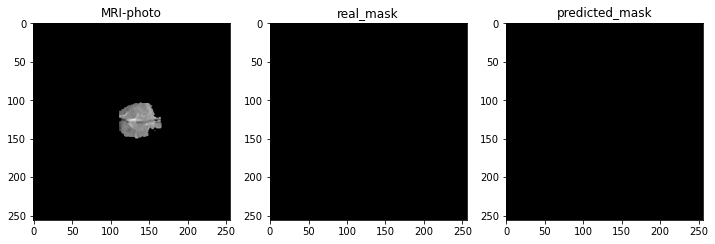

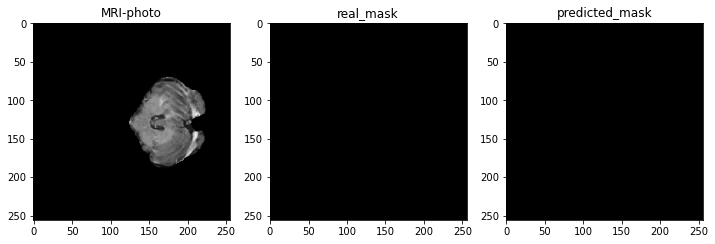

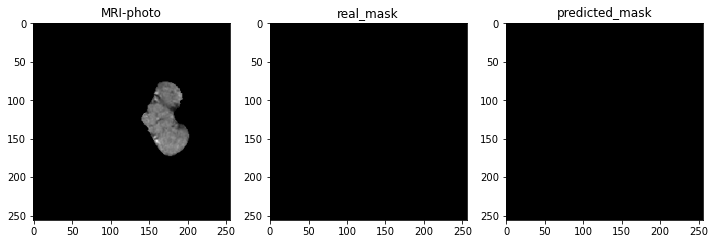

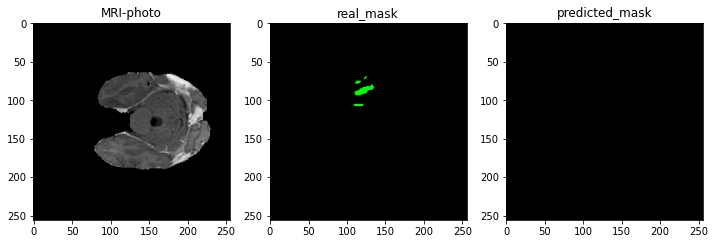

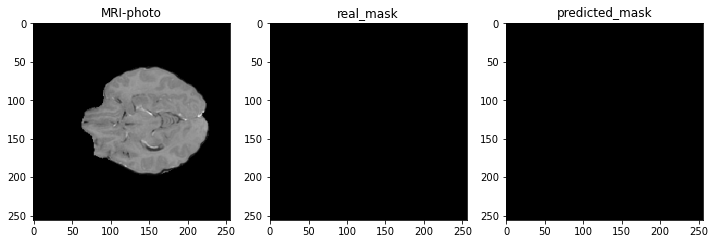

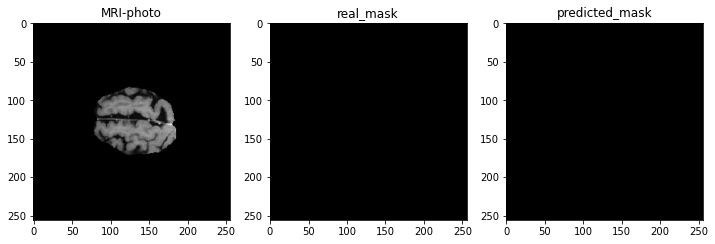

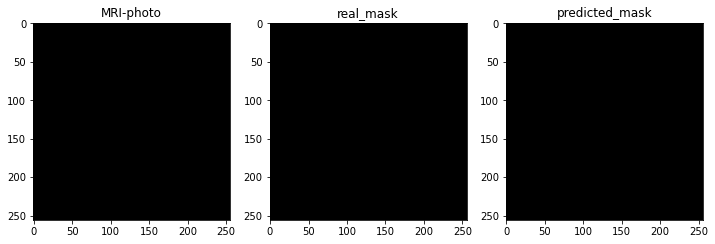

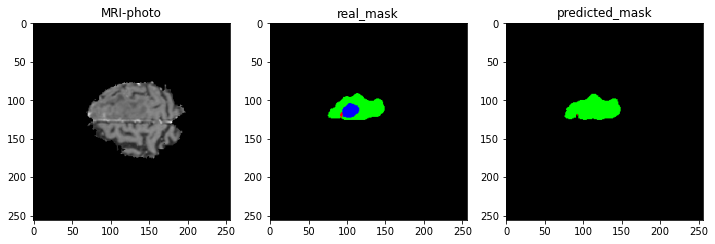

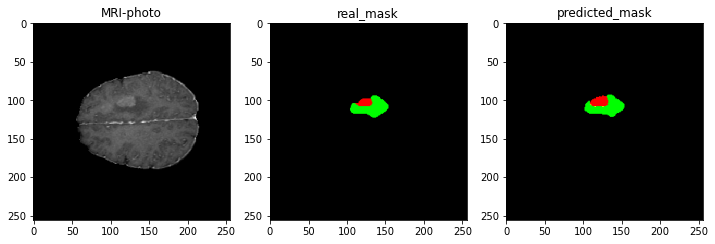

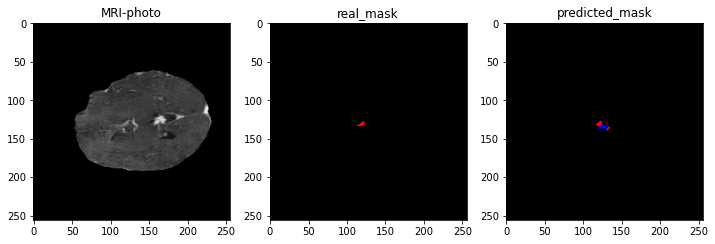

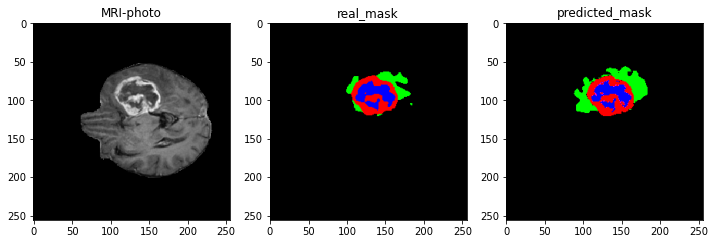

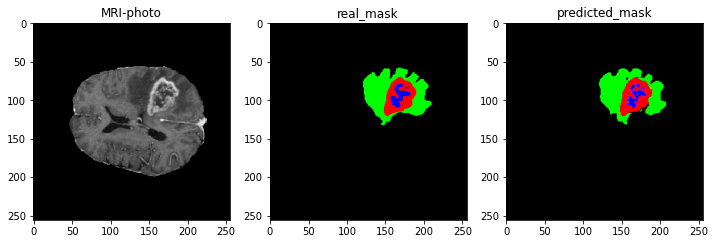

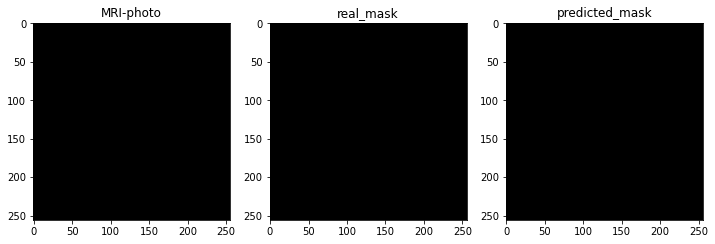

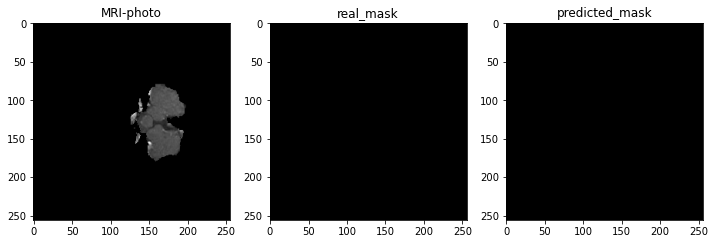

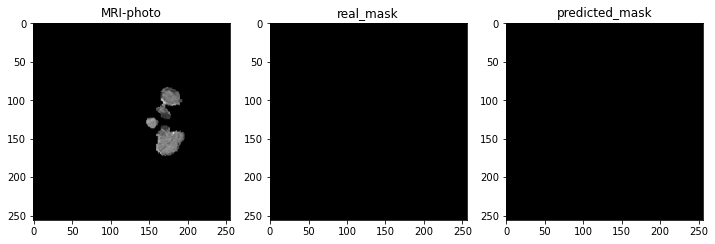

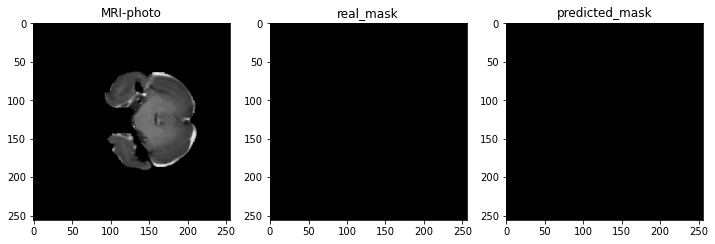

In [33]:
inputs, labels = next(iter(val_loader))

inputs = inputs.to(device)

pred = predict_masks(unet_model, inputs, isDeepLabV3=False)

inputs = inputs.data.cpu().numpy()
inputs = torch.tensor(inputs)
labels = labels.to(device)
labels = labels.data.cpu().numpy()
labels = torch.tensor(labels)

plot_predictions(inputs, labels, pred)

In [34]:
average_dice = show_dices_fot_predict(labels, pred)
average_dice

tensor(1.)
tensor(1.)
tensor(1.)
tensor(4.1322e-09)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.7633)
tensor(0.9036)
tensor(0.3194)
tensor(0.8154)
tensor(0.9198)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


tensor(0.8576)

In [30]:
unet_model = Unet().to(device)
unet_model.load_state_dict(torch.load('models_v2\\unet_with_dropout\\epochs_50\\bce0.3_dice0.7_focal0\\unet_with_dropout'))
unet_model.eval()

Unet(
  (double_conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

In [31]:
from torchvision.models.segmentation import deeplabv3_resnet50

deeplabv3_model = deeplabv3_resnet50(num_classes=3)
deeplabv3_model = deeplabv3_model.to(device)
deeplabv3_model.load_state_dict(torch.load('models\\deeplabv3\\epochs_30\\bce0.5_dice0.5_focal0\\deeplabv3'))
deeplabv3_model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [32]:
num_class = 3
ternaus_model = ResNetUNet(num_class).to(device)

ternaus_model.load_state_dict(torch.load('models_v2\\ternausnet\\epochs_20\\bce0.3_dice0.7_focal0\\ternausnet'))
ternaus_model.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

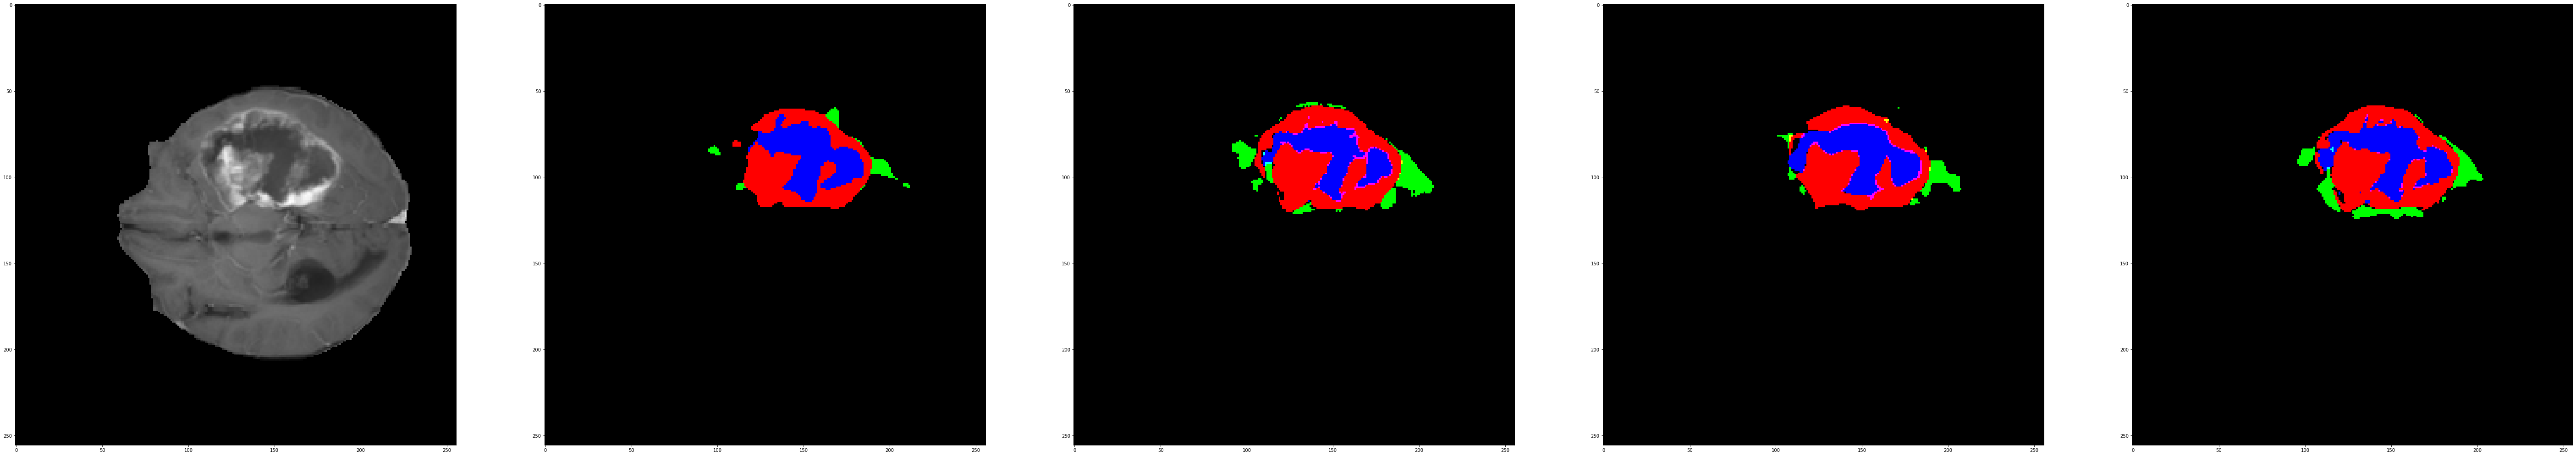

In [37]:
inputs, labels = next(iter(val_loader))

inputs = inputs.to(device)
inputs = inputs.data.cpu().numpy()
inputs = torch.tensor(inputs)
labels = labels.to(device)
labels = labels.data.cpu().numpy()
labels = torch.tensor(labels)

f, axes = plt.subplots(1, 5)
f.set_size_inches(100,100)
image = inputs[1]
image = image.permute(1,2,0)
axes[0].imshow(image)
real_mask = labels[1]
real_mask = real_mask.permute(1,2,0)
axes[1].imshow(real_mask)

pred_unet = predict_masks(unet_model, inputs, isDeepLabV3=False)
unet_mask = pred_unet[1]
unet_mask = unet_mask.permute(1,2,0)
unet_mask.apply_(lambda x: 1 if x > 0.5 else 0)
axes[2].imshow(unet_mask)

pred_deeplab = predict_masks(deeplabv3_model, inputs, isDeepLabV3=True)
deeplab_mask = pred_deeplab[1]
deeplab_mask = deeplab_mask.permute(1,2,0)
deeplab_mask.apply_(lambda x: 1 if x > 0.5 else 0)
axes[3].imshow(deeplab_mask)

pred_ternaus = predict_masks(ternaus_model, inputs, isDeepLabV3=False)
ternaus_mask = pred_ternaus[1]
ternaus_mask = ternaus_mask.permute(1,2,0)
ternaus_mask.apply_(lambda x: 1 if x > 0.5 else 0)
axes[4].imshow(ternaus_mask)

# pred_pix2pix = cv2.imread('/home/podaval/Kochanov_diploma/pytorch-CycleGAN-and-pix2pix/results/brats_pix2pix/test_latest/images/56_fake_B.png')
# axes[5].imshow(pred_pix2pix)

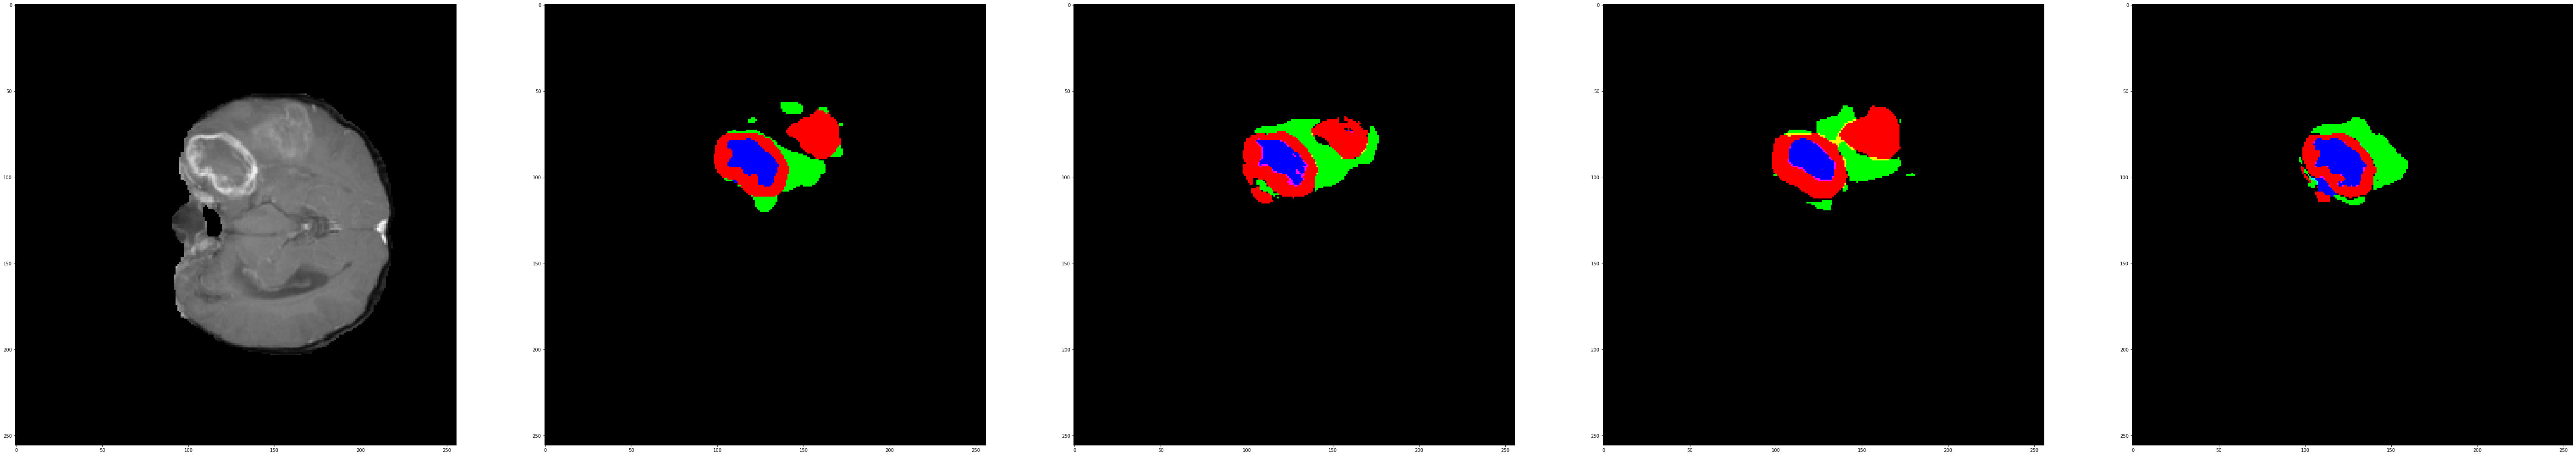

In [50]:
inputs, labels = next(iter(val_loader))

inputs = inputs.to(device)
inputs = inputs.data.cpu().numpy()
inputs = torch.tensor(inputs)
labels = labels.to(device)
labels = labels.data.cpu().numpy()
labels = torch.tensor(labels)

f, axes = plt.subplots(1, 5)
f.set_size_inches(100,100)
image = inputs[1]
image = image.permute(1,2,0)
axes[0].imshow(image)

real_mask = labels[1]
real_mask = real_mask.permute(1,2,0)
axes[1].imshow(real_mask)

pred_unet = predict_masks(unet_model, inputs, isDeepLabV3=False)
unet_mask = pred_unet[1]
unet_mask = unet_mask.permute(1,2,0)
unet_mask.apply_(lambda x: 1 if x > 0.5 else 0)
axes[2].imshow(unet_mask)

pred_deeplab = predict_masks(deeplabv3_model, inputs, isDeepLabV3=True)
deeplab_mask = pred_deeplab[1]
deeplab_mask = deeplab_mask.permute(1,2,0)
deeplab_mask.apply_(lambda x: 1 if x > 0.5 else 0)
axes[3].imshow(deeplab_mask)

pred_ternaus = predict_masks(ternaus_model, inputs, isDeepLabV3=False)
ternaus_mask = pred_ternaus[1]
ternaus_mask = ternaus_mask.permute(1,2,0)
ternaus_mask.apply_(lambda x: 1 if x > 0.5 else 0)
axes[4].imshow(ternaus_mask)

# pred_pix2pix = cv2.imread('/home/podaval/Kochanov_diploma/pytorch-CycleGAN-and-pix2pix/results/brats_pix2pix/test_latest/images/56_fake_B.png')
# axes[5].imshow(pred_pix2pix)